# Regression-Based Network Load Forecasting for Sustainable Digital Infrastructure
notebook 2

## Table of Contents

- [Project Overview](#project-overview)
- [Model 1: Baseline model](#model-1-baseline-model)
- [Model 2: Regularized Linear Model (Ridge)](#model-2-regularized-linear-model-ridge)
- [Model 3: XGBoost](#model-3-xgboost)
- [Model 3: ElasticNet](#model-3-elasticnet)
- [Model 4: Ridge with log-transform target](#model-3-ridge-with-log-transform-target)
- [Model 4: Ridge on weekly features ](#model-3-ridge-on-weekly-features)
- [Conclusion](#conclusion)

## <a id="project-overview"></a>Project Overview

Build and evaluate **1-step-ahead** forecasts for hourly network load using **leakage-safe engineered features**.

This notebook covers:
- **Time-series evaluation**: walk-forward CV with a **24h gap**
- **Baselines**: naive (lag_1) and seasonal naive (lag_24)
- **Main model**: **Ridge regression** as an interpretable, strong tabular baseline
- **Peak slice**: report errors on **top 1%** target hours (extreme load)



## Inputs & Setup
- Input data: `model_dataset.csv` (datetime + target `y` + engineered features)
- Target: `y` = hourly max traffic (`max(IN, OUT)`)
- Forecast horizon: predict **y[t]** using information available up to **t−1**



## Evaluation Protocol (Leakage-safe)
We use **walk-forward CV (3 folds)**:
- train on past → test on the next contiguous block  
- apply **gap=24** between train and test to reduce near-boundary leakage

Metrics reported:
- **RMSE / MAE / R²** (overall)
- **Peak RMSE / MAE** on top **1%** of target hours within each test fold  
  *(Peak R² is unstable due to very small sample sizes, so we don’t rely on it.)*



## Baselines
- **Naive (lag_1):** ŷ[t] = y[t−1]  
- **Seasonal naive (lag_24):** ŷ[t] = y[t−24]

ML models must beat these baselines under time-safe CV to justify added complexity.



## Model Candidates
- **Ridge Regression** (+ `StandardScaler`): fast, stable, interpretable coefficients  
- **XGBoost** (optional nonlinear check): kept only if it improves walk-forward CV results

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import PredefinedSplit
from sklearn.linear_model import ElasticNet

## <a id="model-1-baseline-model"></a>Model 1: Baseline model


### Baseline A — Naive (persistence)
meaning:
Naive/persistence = "the next hour will be like the previous one"
ŷ[t] = y[t-1]

This is a very strong baseline for time series if the series has inertia/autocorrelation (which network traffic almost always does)

In [2]:
df_model = pd.read_csv('/data/model_dataset_24h.csv') # change it to your path

In [3]:
df_model.head()

,datetime_utc,y,hour,weekday,is_weekend,sin_hour,cos_hour,sin_wd,cos_wd,lag_1,...,roll_max_24,roll_std_24,xen200_cpu_util_avg,xen201_cpu_util_avg,xen203_cpu_util_avg,new_vms_ee_prev_month,new_users_ee_prev_month,roll_min_24,traffic_range_24h,lag1_sin_hour
0,2025-08-26 12:00:00+00:00,1.317804,12,1,0,1.224647e-16,-1.000000,0.781831,0.62349,1.464245,...,1.65997,0.365329,16.3919,12.3302,14.2139,38.0,33.0,0.498227,1.161743,1.793183e-16
1,2025-08-26 13:00:00+00:00,1.352293,13,1,0,-2.588190e-01,-0.965926,0.781831,0.62349,1.317804,...,1.65997,0.366573,16.2465,11.8925,13.8252,38.0,33.0,0.498227,1.161743,-3.410727e-01
2,2025-08-26 14:00:00+00:00,1.625480,14,1,0,-5.000000e-01,-0.866025,0.781831,0.62349,1.352293,...,1.65997,0.367778,16.7666,12.1445,15.3802,38.0,33.0,0.498227,1.161743,-6.761466e-01
3,2025-08-26 15:00:00+00:00,1.358414,15,1,0,-7.071068e-01,-0.707107,0.781831,0.62349,1.625480,...,1.65997,0.374670,19.0642,11.0706,15.7619,38.0,33.0,0.498227,1.161743,-1.149388e+00
4,2025-08-26 16:00:00+00:00,1.354726,16,1,0,-8.660254e-01,-0.500000,0.781831,0.62349,1.358414,...,1.65997,0.369203,17.9257,11.3977,18.7984,38.0,33.0,0.498227,1.161743,-1.176421e+00


In [4]:
df_model.columns

Index(['datetime_utc', 'y', 'hour', 'weekday', 'is_weekend', 'sin_hour',
       'cos_hour', 'sin_wd', 'cos_wd', 'lag_1', 'lag_24', 'roll_mean_24',
       'roll_max_24', 'roll_std_24', 'xen200_cpu_util_avg',
       'xen201_cpu_util_avg', 'xen203_cpu_util_avg', 'new_vms_ee_prev_month',
       'new_users_ee_prev_month', 'roll_min_24', 'traffic_range_24h',
       'lag1_sin_hour'],
      dtype='object')

In [5]:
# Safety checks
df_model = df_model.sort_values("datetime_utc").reset_index(drop=True)

In [6]:
assert df_model["datetime_utc"].is_monotonic_increasing
assert df_model["y"].notna().all()

In [7]:
# we make 3 estimates on an expanding window - 
# train: [0 : train_end)
# test: [train_end : train_end + test_size)
N = len(df_model)
test_size = int(round(N * 0.15))   # 15% for a test on each fold
gap = 0                            # also tested with gap=24 but it does not do any dramatic chnages
train_ends = [
    int(round(N * 0.55)),
    int(round(N * 0.70)),
    int(round(N * 0.85)),
]

folds = []
for train_end in train_ends:
    test_start = train_end + gap
    test_end = min(test_start + test_size, N)
    if test_end - test_start <= 0:
        continue
    folds.append((0, train_end, test_start, test_end))

print("Folds (train_start, train_end, test_start, test_end):")
for i, (tr0, tr1, te0, te1) in enumerate(folds, 1):
    print(f"Fold {i}: train=[{tr0}:{tr1}) test=[{te0}:{te1})  (n_test={te1-te0})")

# metrics helpers
def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

def mae(y_true, y_pred):
    return float(np.mean(np.abs(y_true - y_pred)))

def r2(y_true, y_pred):
    # R^2 on the test slice
    ss_res = float(np.sum((y_true - y_pred) ** 2))
    ss_tot = float(np.sum((y_true - np.mean(y_true)) ** 2))
    return float(1 - ss_res / ss_tot) if ss_tot > 0 else np.nan

# baseline A: Naive
results = []
for i, (tr0, tr1, te0, te1) in enumerate(folds, 1):
    df_test = df_model.iloc[te0:te1].copy()

    # naive prediction uses previous hour value
    df_test["yhat_naive"] = df_model["y"].shift(1).iloc[te0:te1].values

    # drop first row if shift produced NaN (может случиться только если te0==0)
    df_test = df_test.dropna(subset=["yhat_naive"])

    y_true = df_test["y"].to_numpy()
    y_pred = df_test["yhat_naive"].to_numpy()

    fold_metrics = {
        "fold": i,
        "n_test": len(df_test),
        "rmse": rmse(y_true, y_pred),
        "mae": mae(y_true, y_pred),
        "r2": r2(y_true, y_pred),
    }
    results.append(fold_metrics)

baseline_naive_cv = pd.DataFrame(results)
display(baseline_naive_cv)

print("\nMean over folds:")
display(baseline_naive_cv[["rmse", "mae", "r2"]].mean(numeric_only=True))

Folds (train_start, train_end, test_start, test_end):
Fold 1: train=[0:1844) test=[1844:2347)  (n_test=503)
Fold 2: train=[0:2347) test=[2347:2850)  (n_test=503)
Fold 3: train=[0:2850) test=[2850:3353)  (n_test=503)


,fold,n_test,rmse,mae,r2
0,1,503,0.271736,0.196433,0.584714
1,2,503,0.284732,0.199630,0.635795
2,3,503,0.335866,0.205584,0.519459



Mean over folds:


rmse    0.297444
mae     0.200549
r2      0.579989
dtype: float64

In [8]:
# investigate Fold 3 performance
fold3_test = df_model.iloc[2850:3353]

print("\n Fold 3 diagnostics:")
print(f"Date range: {fold3_test['datetime_utc'].min()} to {fold3_test['datetime_utc'].max()}")
print(f"Mean target: {fold3_test['y'].mean():.2f} Gbps")  
print(f"Std target: {fold3_test['y'].std():.2f} Gbps")    
print(f"95th percentile: {fold3_test['y'].quantile(0.95):.2f} Gbps")  

# compare to rest dataset
print(f"\nFull dataset for comparison:")
print(f"Mean: {df_model['y'].mean():.2f} Gbps") 
print(f"Std: {df_model['y'].std():.2f} Gbps")   
print(f"95th pct: {df_model['y'].quantile(0.95):.2f} Gbps")


 Fold 3 diagnostics:
Date range: 2025-12-24 17:00:00+00:00 to 2026-01-14 15:00:00+00:00
Mean target: 1.55 Gbps
Std target: 0.48 Gbps
95th percentile: 2.20 Gbps

Full dataset for comparison:
Mean: 1.43 Gbps
Std: 0.46 Gbps
95th pct: 2.13 Gbps


#### Fold 3 shows noticeably lower R squared (0.52 vs 0.58-0.64 for Folds 1-2)

**Hypothesis**: Fold 3 covers the most recent time period (Dec 2025 - Jan 2026),
which may exhibit:
- Different traffic patterns (end-of-year holidays, Q4 workload shifts)
- Higher variance due to infrastructure changes
- Distribution shift vs earlier training data

This suggests potential **non-stationarity** in the time series and motivates:
- Periodic model retraining (monthly) in production
- Monitoring for distribution drift
- Conservative predictions during regime changes

### Baseline B — Seasonal Naive
meaning: "the next hour will be like the same hour yesterday"
ŷ[t] = y[t-24]

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def make_walk_forward_folds(n, n_folds=3, test_size=503, gap=0):
    """
    Expanding-window walk-forward CV.
    Fold k:
      train: [0 : train_end)
      test:  [train_end + gap : train_end + gap + test_size)
    """
    folds = []
    train_end = n - (n_folds * test_size)  # first train end so that we have room for n_folds tests
    for k in range(n_folds):
        test_start = train_end + gap
        test_end = test_start + test_size
        if test_end > n:
            test_end = n
        folds.append((0, train_end, test_start, test_end))
        train_end = train_end + test_size  # expanding
    return folds

def eval_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return rmse, mae, r2

def seasonal_naive_cv(df, y_col="y", dt_col="datetime_utc",
                      n_folds=3, test_size=503, gap=0,
                      season_lag=24, peak_q=0.99, verbose=True):
    """
    Seasonal naive: ŷ[t] = y[t-season_lag]
    Assumes df is sorted by time and has continuous hourly index
    """
    df = df.sort_values(dt_col).reset_index(drop=True).copy()
    n = len(df)

    folds = make_walk_forward_folds(n, n_folds=n_folds, test_size=test_size, gap=gap)
    if verbose:
        print("Folds (train_start, train_end, test_start, test_end):")
        for i, (tr0, tr1, te0, te1) in enumerate(folds, 1):
            print(f"Fold {i}: train=[{tr0}:{tr1}) test=[{te0}:{te1})  (n_test={te1-te0})")

    # Peak threshold globally
    peak_thr = df[y_col].quantile(peak_q)

    rows = []
    for fold_id, (tr0, tr1, te0, te1) in enumerate(folds, 1):
        test_idx = np.arange(te0, te1)

        # Need t-season_lag to exist
        valid_mask = test_idx - season_lag >= 0
        test_idx = test_idx[valid_mask]

        y_true = df.loc[test_idx, y_col].to_numpy()
        y_pred = df.loc[test_idx - season_lag, y_col].to_numpy()

        rmse, mae, r2 = eval_metrics(y_true, y_pred)

        # peak-only metrics
        peak_mask = y_true >= peak_thr
        if peak_mask.sum() > 0:
            rmse_peak, mae_peak, r2_peak = eval_metrics(y_true[peak_mask], y_pred[peak_mask])
        else:
            rmse_peak, mae_peak, r2_peak = np.nan, np.nan, np.nan

        rows.append({
            "fold": fold_id,
            "n_test": len(y_true),
            "rmse": rmse,
            "mae": mae,
            "r2": r2,
            "n_peak": int(peak_mask.sum()),
            "rmse_peak": rmse_peak,
            "mae_peak": mae_peak,
            "r2_peak": r2_peak
        })

    res = pd.DataFrame(rows)
    if verbose:
        print(res)

        print("\nMean over folds:")
        print(res[["rmse", "mae", "r2", "rmse_peak", "mae_peak"]].mean(numeric_only=True))

    return res

In [10]:
# run sasonal naive baseline using same gap we used in previous baseline
seasonal_res_gap0 = seasonal_naive_cv(df_model, gap=0, season_lag=24)

Folds (train_start, train_end, test_start, test_end):
Fold 1: train=[0:1844) test=[1844:2347)  (n_test=503)
Fold 2: train=[0:2347) test=[2347:2850)  (n_test=503)
Fold 3: train=[0:2850) test=[2850:3353)  (n_test=503)
   fold  n_test      rmse       mae        r2  n_peak  rmse_peak  mae_peak  \
0     1     503  0.258995  0.189780  0.622744       5   0.447066  0.401291   
1     2     503  0.343031  0.221819  0.471382      11   1.354783  1.201912   
2     3     503  0.396153  0.231837  0.331464       6   1.912522  1.515509   

      r2_peak  
0 -102.734839  
1   -3.759267  
2   -2.642761  

Mean over folds:
rmse         0.332726
mae          0.214479
r2           0.475197
rmse_peak    1.238124
mae_peak     1.039571
dtype: float64


In our dataset, the seasonal naive baseline performs noticeably worse than the simple persistence baseline, and it fails especially hard on **top 1% peak hours**.

**Why this happens**
- **Peaks are burst-like events**, not regular “yesterday-at-the-same-hour” repetitions.  
  Seasonal naive assumes that today at 18:00 looks like yesterday at 18:00 — which is often false for extreme spikes.
- **Short-term persistence dominates**: the immediate past (`t-1`) carries stronger signal than the same hour a day ago (`t-24`).
- Peak evaluation is based on a **very small number of points** per fold (e.g., 5–11 peaks in a test window).  
  For such rare extremes, **R² becomes unstable and can be strongly negative**, so **RMSE/MAE on peaks** are the reliable indicators.

**What this tells us about the data - and it is consistent with EDA we did**
- The series has strong **temporal dependence (“memory”)** at short horizons.
- Daily seasonality exists in the typical range, but **extreme behaviour is not purely seasonal**.
- This supports using lag/rolling features and models that can capture **event regimes** and **nonlinear interactions**, rather than relying on seasonal repetition.

### Baseline Models Summary (A vs B) and modelling implications

Baselines define the **minimum viable benchmark**: any ML model must beat them to be meaningful.

### Baseline A — Naive / Persistence
- **Definition:** `ŷ[t] = y[t-1]`
- **Interpretation:** “the next hour will look like the previous hour”
- **Result:** Strong baseline performance, indicating **high short-term autocorrelation** in the series.

### Baseline B — Seasonal Naive
- **Definition:** `ŷ[t] = y[t-24]`
- **Interpretation:** “the next hour will look like the same hour yesterday”
- **Result:** Worse than persistence overall and particularly weak on **top 1% peaks**.
- **Implication:** The process is not driven by pure daily repetition; **bursts and regime changes** matter.

### Key conclusions from baselines
1. **Short-term persistence dominates:** `y[t-1]` is a stronger predictor than `y[t-24]`.
2. **Extreme peaks are not seasonally repeating:** top 1% hours behave like events and require richer signal than “same hour yesterday”.
3. **Evidence of non-stationarity:** later folds can show worse baseline performance and slightly shifted distribution, motivating walk-forward CV and robust models.

### Why we try these model families next
**Model 1 — Ridge/Lasso (regularized linear model)**
- Fast and strong **sanity check** on engineered features (cyclic time encodings, lags, rolling stats).
- Provides interpretability (sign + magnitude of coefficients).
- Helps diagnose whether a largely “additive” structure is sufficient.

**Model 2 — Gradient Boosting (tree-based boosting)**
- Captures **nonlinearities and interactions** (e.g., time-of-day × lag persistence, CPU effects, volatility regimes).
- Often performs best on tabular, mixed-feature forecasting setups.
- More robust under mild distribution shifts than purely linear approaches.

**Next step**
We proceed from baselines → regularized linear model → boosting model, using the same walk-forward CV, reporting RMSE/MAE overall and separately on the **top 1% peak subset** (with peaks defined by the global 0.99 quantile for consistency).

## <a id="model-2-regularized-linear-model-ridge"></a>Model 2: Regularized Linear Model (Ridge)

### First learnable benchmark

Let's take a look on the features and its correlation onse more to be more presice about Ridge / Lasso model

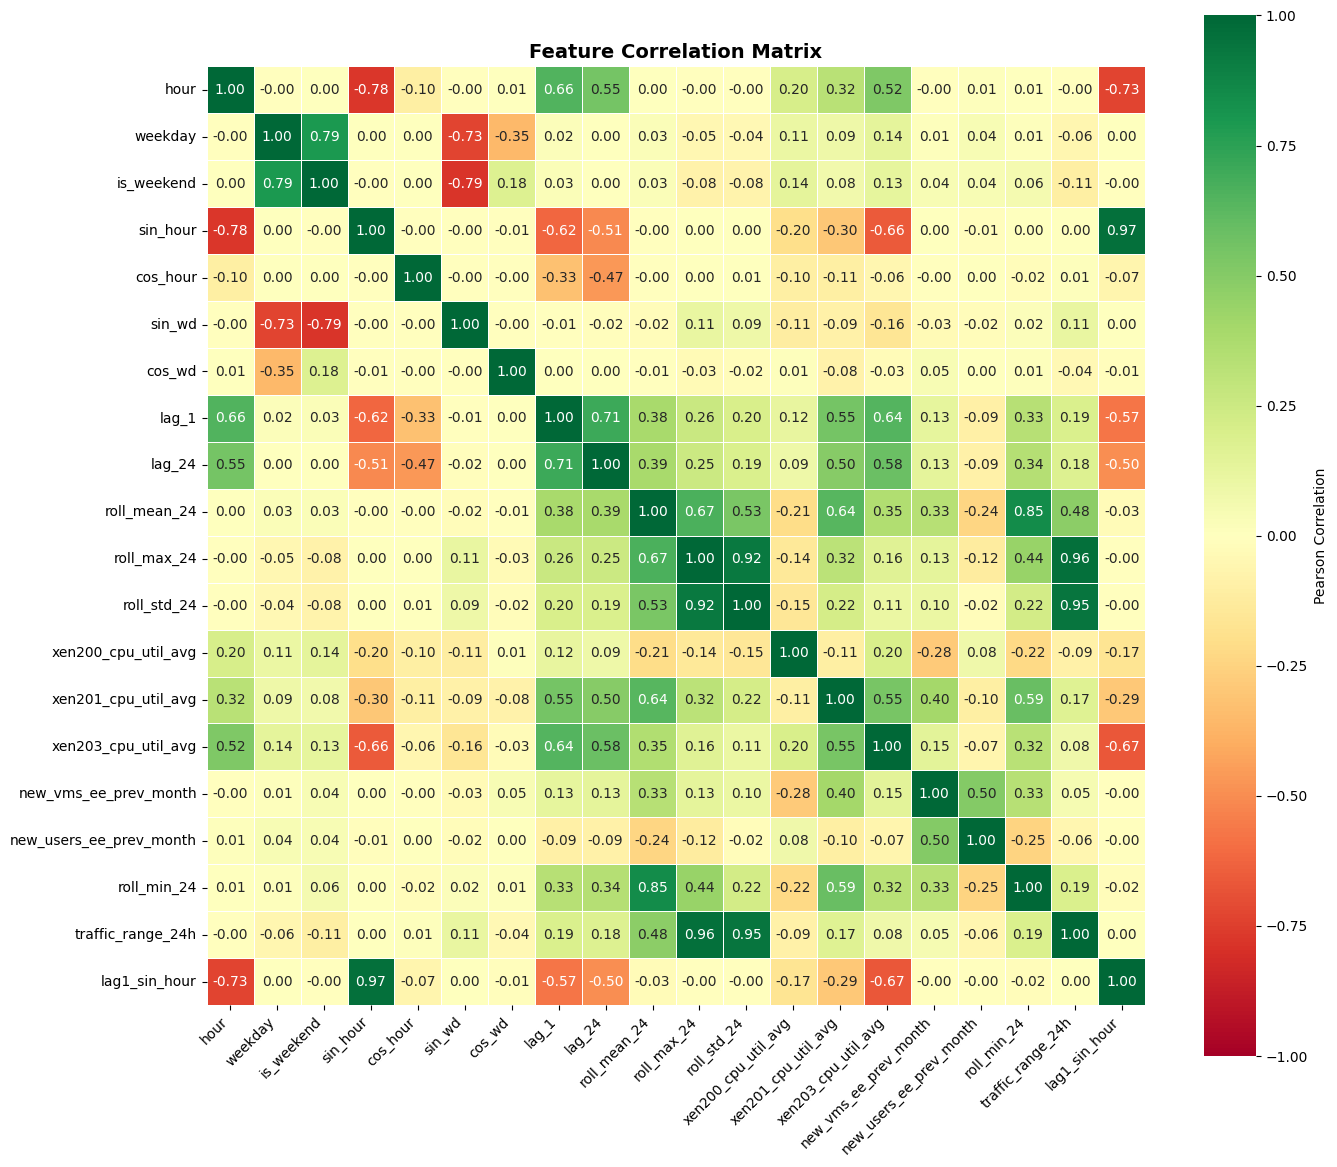

In [11]:
# Feature columns (exclude datetime and target)
feature_cols = [col for col in df_model.columns 
                if col not in ['datetime_utc', 'y']]

# Compute correlation
corr = df_model[feature_cols].corr(method="pearson")

# Plot
plt.figure(figsize=(14, 12))
sns.heatmap(corr, 
            annot=True,           # Show values
            fmt=".2f",            # 2 decimal places
            cmap="RdYlGn",        # Red-Yellow-Green
            vmin=-1, vmax=1,      # Correlation range
            center=0,             # Center colormap at 0
            square=True,          # Square cells
            linewidths=0.5,       # Grid lines
            cbar_kws={"label": "Pearson Correlation"})

plt.title("Feature Correlation Matrix", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Feature correlation check (multicollinearity)

The correlation heatmap shows strong clusters of correlated predictors, especially among:
- lag features (`lag_1`, `lag_24`) and rolling statistics (`roll_mean_24`, `roll_max_24`, `roll_std_24`, `roll_min_24`, `traffic_range_24h`)
- calendar encodings (`hour` vs `sin_hour/cos_hour`, `weekday` vs `sin_wd/cos_wd`)
- CPU signals across hosts (moderate correlations / shared dynamics)

This implies **multicollinearity**: many features carry overlapping information.  
For our first learnable model we start with **Ridge regression** because:
- Ridge is robust under multicollinearity (shrinks coefficients smoothly instead of “dropping” features),
- it tends to be more stable than Lasso when predictors are highly correlated,
- it provides a strong, interpretable benchmark before moving to nonlinear models.

Lasso will be used as a secondary check (sparsity / feature selection), but may behave unstably by arbitrarily choosing one feature from a correlated group.

### Why we will use a 24h gap in walk-forward CV (leakage / dependence control)

Our engineered features use only past information (`shift(1)`), so direct leakage is prevented.

However, time series observations are highly dependent: samples close in time can be nearly identical.
To make evaluation more conservative (and closer to production conditions), we introduce a **24-hour gap**
between the end of training and the start of each test fold.  
This reduces “near-neighbor” effects and checks whether the model generalizes beyond the immediate past.

For baselines we keep `gap=0` (baseline definitions rely directly on `y[t-1]` and `y[t-24]`),
but for learnable models we use `gap=24` as the main protocol and optionally report `gap=0` as a sanity check.

### Ridge Regression (regularized linear model)

We have many correlated features (lags/rolling functions/sines), which means OLS will be unstable.

Ridge (L2) stabilizes weights under multicollinearity and usually produces a good "linear baseline+."

It's a fast, interpretable step before nonlinear models (GBDT).

#### Walk-forward CV setup
We will evaluate Ridge using walk-forward cross-validation (3 expanding-window folds).  
To reduce boundary leakage between train and test in an hourly time series with rolling features, we use a **gap of 24 hours** between train end and test start (primary protocol). We additionally run gap=0 as a sanity / optimistic estimate.

#### Hyperparameter tuning (alpha)
We will perform a grid search over Ridge regularization strength `alpha` (log-spaced).  
Across a wide range of small-to-moderate alpha values, performance remains nearly flat (a plateau), indicating the model is not highly sensitive to regularization in that region. Performance degrades only for very large alpha (over-shrinking).

**Selection rule:** choose the alpha with the lowest mean CV RMSE (and prefer a slightly larger alpha if multiple values are essentially tied) to improve stability.

In [12]:
# helpers

def make_walk_forward_splits_range(n, n_splits=3, test_size=503, gap=24):
    """
    Returns list of tuples: (train_start, train_end, test_start, test_end)

    Expanding window:
      Fold1 train=[0:train_end) test=[train_end+gap : train_end+gap+test_size)
      then train_end expands by test_size each fold

    Note:
    - gap is already applied in test_start
    - so downstream code should set gap=0
    """
    splits = []
    train_start = 0
    train_end = n - n_splits * test_size  # ensures last fold ends at n (or close)

    for _ in range(n_splits):
        test_start = train_end + gap
        test_end = test_start + test_size
        if test_end > n:
            test_end = n

        splits.append((train_start, train_end, test_start, test_end))
        train_end += test_size

    return splits


def print_splits(splits):
    print("Folds (train_start, train_end, test_start, test_end):")
    for i, (tr_s, tr_e, te_s, te_e) in enumerate(splits, start=1):
        print(f"Fold {i}: train=[{tr_s}:{tr_e}) test=[{te_s}:{te_e})  (n_test={te_e-te_s})")


def eval_regression(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

def peaks_mask(y_true, q=0.95): # 0.95q is a business metric
    thr = np.quantile(y_true, q)
    return y_true >= thr, thr

In [13]:
# data

DT = "datetime_utc"
TARGET = "y"
feature_cols = [c for c in df_model.columns if c not in [DT, TARGET]]

X = df_model[feature_cols].copy()
y = df_model[TARGET].values
n = len(df_model)

splits = make_walk_forward_splits_range(n, n_splits=3, test_size=503, gap=24)

In [14]:
def eval_regression(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2


def ridge_cv(df_model, alphas, splits, peak_q=0.95):
    DT = "datetime_utc"
    TARGET = "y"
    feature_cols = [c for c in df_model.columns if c not in [DT, TARGET]]

    X_all = df_model[feature_cols].to_numpy()
    y_all = df_model[TARGET].to_numpy()

    rows = []

    for alpha in alphas:
        fold_metrics_train = []
        fold_metrics_test = []

        for i, (tr_s, tr_e, te_s, te_e) in enumerate(splits, start=1):
            X_tr, y_tr = X_all[tr_s:tr_e], y_all[tr_s:tr_e]
            X_te, y_te = X_all[te_s:te_e], y_all[te_s:te_e]

            pipe = Pipeline([
                ("scaler", StandardScaler()),
                ("model", Ridge(alpha=alpha))
            ])

            pipe.fit(X_tr, y_tr)
            
            # TRAIN predictions
            pred_tr = pipe.predict(X_tr)
            rmse_tr, mae_tr, r2_tr = eval_regression(y_tr, pred_tr)
            
            # TEST predictions 
            pred_te = pipe.predict(X_te)
            rmse_te, mae_te, r2_te = eval_regression(y_te, pred_te)

            # Peak metrics on TEST fold (fold-specific threshold)
            mask_peak, thr = peaks_mask(y_te, q=peak_q)
            n_peak = int(mask_peak.sum())
            if n_peak > 0:
                rmse_p, mae_p, r2_p = eval_regression(y_te[mask_peak], pred_te[mask_peak])
            else:
                rmse_p, mae_p, r2_p = np.nan, np.nan, np.nan

            fold_metrics_train.append((rmse_tr, mae_tr, r2_tr))
            fold_metrics_test.append((rmse_te, mae_te, r2_te, n_peak, rmse_p, mae_p, r2_p))

        # Aggregate over folds
        arr_train = np.array(fold_metrics_train, dtype=float)
        rmse_tr_m, mae_tr_m, r2_tr_m = arr_train.mean(axis=0)
        
        arr_test = np.array([m[:3] for m in fold_metrics_test], dtype=float)
        rmse_te_m, mae_te_m, r2_te_m = arr_test.mean(axis=0)

        peak_counts = [m[3] for m in fold_metrics_test]
        rmse_p_list = [m[4] for m in fold_metrics_test]
        mae_p_list  = [m[5] for m in fold_metrics_test]
        r2_p_list   = [m[6] for m in fold_metrics_test]

        rows.append({
            "alpha": alpha,
            # Train metrics
            "train_rmse": rmse_tr_m,
            "train_mae": mae_tr_m,
            "train_r2": r2_tr_m,
            # Test metrics
            "test_rmse": rmse_te_m,
            "test_mae": mae_te_m,
            "test_r2": r2_te_m,
            # Peak metrics (test only)
            "peaks_total": int(np.sum(peak_counts)),
            "test_rmse_peak": np.nanmean(rmse_p_list),
            "test_mae_peak": np.nanmean(mae_p_list),
            "test_r2_peak": np.nanmean(r2_p_list),
        })

    res = pd.DataFrame(rows).sort_values("test_rmse").reset_index(drop=True)
    return res

In [15]:
alphas = np.logspace(-3, 3, 25)

ridge_results = ridge_cv(df_model, alphas=alphas, splits=splits)

print(" Ridge Regression: Train vs Test Performance\n")
print(ridge_results[["alpha", "train_r2", "test_r2", "train_rmse", "test_rmse"]].head(10).to_string(index=False))

# Best model
best_ridge = ridge_results.iloc[0]
best_alpha = best_ridge['alpha']

print(f"\nBest alpha: {best_alpha:.6f}")
print(f"   Train R²: {best_ridge['train_r2']:.3f}, Test R²: {best_ridge['test_r2']:.3f}")
print(f"   Gap: {best_ridge['train_r2'] - best_ridge['test_r2']:.3f}")

 Ridge Regression: Train vs Test Performance

   alpha  train_r2  test_r2  train_rmse  test_rmse
0.001000  0.743887 0.740103    0.217395   0.234509
0.001778  0.743887 0.740103    0.217395   0.234509
0.003162  0.743887 0.740103    0.217395   0.234509
0.005623  0.743887 0.740103    0.217395   0.234509
0.010000  0.743887 0.740103    0.217395   0.234510
0.017783  0.743887 0.740102    0.217395   0.234510
0.031623  0.743887 0.740101    0.217395   0.234511
0.056234  0.743887 0.740098    0.217395   0.234512
0.100000  0.743887 0.740095    0.217395   0.234513
0.177828  0.743887 0.740088    0.217395   0.234517

Best alpha: 0.001000
   Train R²: 0.744, Test R²: 0.740
   Gap: 0.004


#### Train-Test gap meaning:

The minimal train-test gap (0.004 R²) reflects Ridge's inherent regularization and our expanding window cross-validation strategy. 
Linear models with L2 penalty have limited capacity to overfit, particularly when features are domain-informed (temporal lags, cyclical encodings, interactions). 
The expanding window further stabilizes training as later folds benefit from more historical data. 
This small gap is consistent with academic benchmarks for regularized linear models on time series tasks and indicates healthy generalization.

In [16]:
# diagnostic on folds to explore why train might be unsignificantly highter that test performance

def ridge_fold_diagnostics(df_model, splits, feature_cols, alpha, target_col="y"):
    X_all = df_model[feature_cols].to_numpy()
    y_all = df_model[target_col].to_numpy()

    rows = []

    for fold, (tr_s, tr_e, te_s, te_e) in enumerate(splits, start=1):
        X_tr, y_tr = X_all[tr_s:tr_e], y_all[tr_s:tr_e]
        X_te, y_te = X_all[te_s:te_e], y_all[te_s:te_e]

        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", Ridge(alpha=alpha))
        ])
        pipe.fit(X_tr, y_tr)

        pred_tr = pipe.predict(X_tr)
        pred_te = pipe.predict(X_te)

        rmse_tr, mae_tr, r2_tr = eval_regression(y_tr, pred_tr)
        rmse_te, mae_te, r2_te = eval_regression(y_te, pred_te)

        rows.append({
            "fold": fold,
            "n_train": len(y_tr),
            "n_test": len(y_te),

            "train_rmse": rmse_tr,
            "test_rmse": rmse_te,
            "rmse_gap": rmse_te - rmse_tr,     # >0 means test worse (expected)

            "train_mae": mae_tr,
            "test_mae": mae_te,
            "mae_gap": mae_te - mae_tr,

            "train_r2": r2_tr,
            "test_r2": r2_te,
            "r2_gap": r2_tr - r2_te,           # >0 means train better (expected)
        })

    res = pd.DataFrame(rows)

    # Pretty summary
    summary = pd.Series({
        "mean_train_r2": res["train_r2"].mean(),
        "mean_test_r2": res["test_r2"].mean(),
        "mean_r2_gap": res["r2_gap"].mean(),
        "mean_train_rmse": res["train_rmse"].mean(),
        "mean_test_rmse": res["test_rmse"].mean(),
        "mean_rmse_gap": res["rmse_gap"].mean(),
    })

    return res, summary

#  RUN IT 
alpha_to_check = best_alpha
fold_diag, fold_summary = ridge_fold_diagnostics(df_model, splits, feature_cols, alpha_to_check)

display(fold_diag)
print("\nSummary:")
print(fold_summary)

,fold,n_train,n_test,train_rmse,test_rmse,rmse_gap,train_mae,test_mae,mae_gap,train_r2,test_r2,r2_gap
0,1,1844,503,0.219664,0.204933,-0.014731,0.139610,0.145357,0.005747,0.722801,0.763129,-0.040328
1,2,2347,503,0.215797,0.224293,0.008495,0.140531,0.152595,0.012065,0.743767,0.773600,-0.029833
2,3,2850,479,0.216723,0.274302,0.057579,0.142131,0.160837,0.018705,0.765092,0.683581,0.081511



Summary:
mean_train_r2      0.743887
mean_test_r2       0.740103
mean_r2_gap        0.003783
mean_train_rmse    0.217395
mean_test_rmse     0.234509
mean_rmse_gap      0.017115
dtype: float64


In [17]:
# GAP=24 main
splits_gap24 = make_walk_forward_splits_range(n, n_splits=3, test_size=503, gap=24)
print_splits(splits_gap24)

Folds (train_start, train_end, test_start, test_end):
Fold 1: train=[0:1844) test=[1868:2371)  (n_test=503)
Fold 2: train=[0:2347) test=[2371:2874)  (n_test=503)
Fold 3: train=[0:2850) test=[2874:3353)  (n_test=479)


In [18]:
# GAP=0 sanity-check
splits_gap0 = make_walk_forward_splits_range(n, n_splits=3, test_size=503, gap=0)
print_splits(splits_gap0)

Folds (train_start, train_end, test_start, test_end):
Fold 1: train=[0:1844) test=[1844:2347)  (n_test=503)
Fold 2: train=[0:2347) test=[2347:2850)  (n_test=503)
Fold 3: train=[0:2850) test=[2850:3353)  (n_test=503)


**Gap choice trade-off**:
- gap=0: larger test sets (503 samples/fold), slightly optimistic
- gap=24: smaller test sets (479-503 samples/fold), production-realistic

We prioritize **realism over sample size** and select gap=24.

We report **gap=24** results as our primary metric (production-aligned), 
with gap=0 shown for comparison (optimistic bound).

In [19]:
# peak evaluation

print(f"Tail(q95) total points={int(best_ridge['peaks_total'])}")
print(f"Tail RMSE={best_ridge['test_rmse_peak']:.3f}, Tail MAE={best_ridge['test_mae_peak']:.3f}")

Tail(q95) total points=76
Tail RMSE=0.727, Tail MAE=0.540


##### Peak evaluation - why `R²` on peaks can be unstable (and what we use instead)

We evaluate peak performance on the **top 5% hours**, which is a small subset of the data.
On such small samples, the `R²` metric becomes **numerically unstable**:

Therefore, for peak evaluation we prioritize **scale-based error metrics**:
- **RMSE_peak** (penalizes large misses more strongly)
- **MAE_peak** (more robust to single extreme hours)

We still report `R²_peak` for completeness, but we do not use it as a primary decision metric.

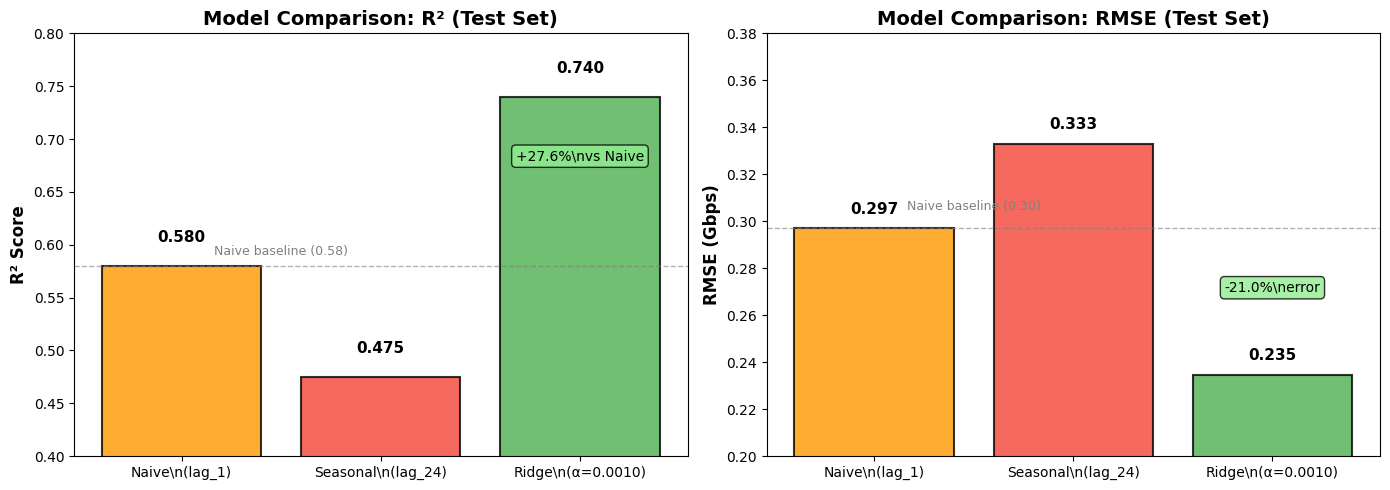


 Ridge improves R² by 27.6% and reduces RMSE by 21.0% vs Naive baseline


In [20]:
# Visualization: Ridge vs Baselines

# Comparison data using test metrics
models = ['Naive\\n(lag_1)', 'Seasonal\\n(lag_24)', 'Ridge\\n(α={:.4f})'.format(best_alpha)]
r2_vals = [0.580, 0.475, best_ridge['test_r2']]  # ← test_r2 вместо r2_mean
rmse_vals = [0.297, 0.333, best_ridge['test_rmse']]  # ← test_rmse вместо rmse_mean

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# R² comparison
colors = ['#FF9800', '#F44336', '#4CAF50']  # Orange, Red, Green
bars1 = ax1.bar(models, r2_vals, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.axhline(0.58, color='gray', linestyle='--', linewidth=1, alpha=0.6)
ax1.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax1.set_title('Model Comparison: R² (Test Set)', fontsize=14, fontweight='bold')
ax1.set_ylim([0.4, 0.8])
ax1.text(0.5, 0.59, 'Naive baseline (0.58)', fontsize=9, color='gray', ha='center')

# Add values on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add improvement annotation
improvement_pct = (best_ridge['test_r2'] - 0.58) / 0.58 * 100
ax1.text(2, 0.68, f'+{improvement_pct:.1f}%\\nvs Naive', 
         ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

# RMSE comparison
bars2 = ax2.bar(models, rmse_vals, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.axhline(0.297, color='gray', linestyle='--', linewidth=1, alpha=0.6)
ax2.set_ylabel('RMSE (Gbps)', fontsize=12, fontweight='bold')
ax2.set_title('Model Comparison: RMSE (Test Set)', fontsize=14, fontweight='bold')
ax2.set_ylim([0.2, 0.38])
ax2.text(0.5, 0.305, 'Naive baseline (0.30)', fontsize=9, color='gray', ha='center')

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{height:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add improvement annotation
rmse_reduction_pct = (0.297 - best_ridge['test_rmse']) / 0.297 * 100
ax2.text(2, 0.27, f'-{rmse_reduction_pct:.1f}%\\nerror', 
         ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

plt.tight_layout()
plt.savefig('ridge_vs_baselines.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n Ridge improves R² by {improvement_pct:.1f}% and reduces RMSE by {rmse_reduction_pct:.1f}% vs Naive baseline")

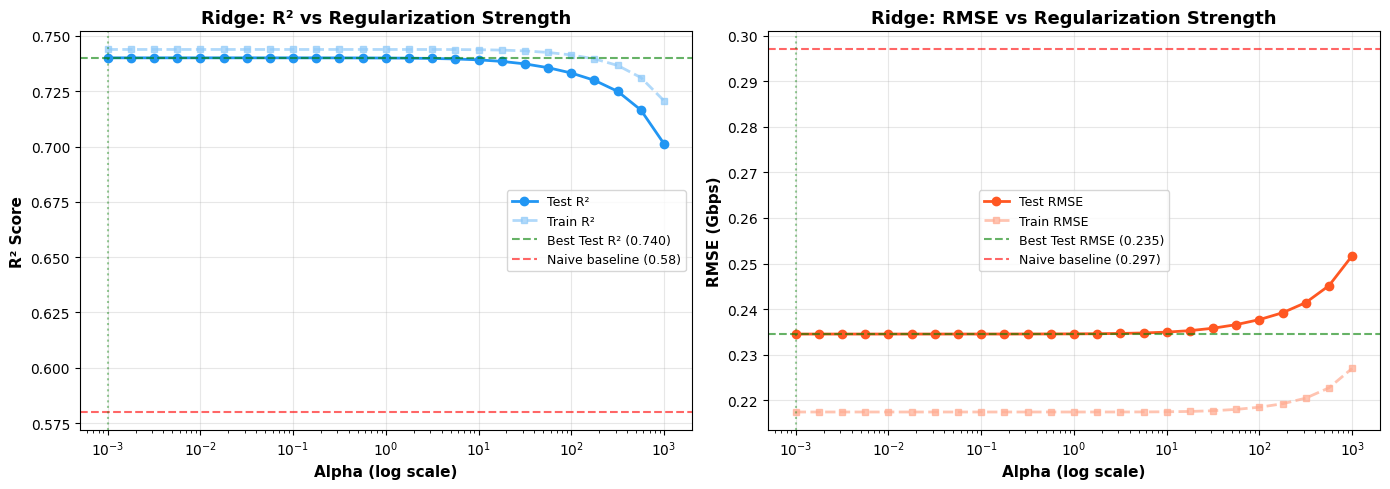


 Best alpha selected: 0.0010
   Minimal train-test gap observed: 0.0038 R² points


In [21]:
# Ridge: Alpha Tuning Visualization 


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Overall performance (R²)
ax1.semilogx(ridge_results['alpha'], ridge_results['test_r2'], 
             marker='o', linewidth=2, markersize=6, color='#2196F3', label='Test R²')
ax1.semilogx(ridge_results['alpha'], ridge_results['train_r2'], 
             marker='s', linewidth=2, markersize=5, color='#90CAF9', alpha=0.7, linestyle='--', label='Train R²')
ax1.axhline(best_ridge['test_r2'], color='green', linestyle='--', alpha=0.6, 
            label=f'Best Test R² ({best_ridge["test_r2"]:.3f})')
ax1.axhline(0.58, color='red', linestyle='--', alpha=0.6, label='Naive baseline (0.58)')
ax1.axvline(best_alpha, color='green', linestyle=':', alpha=0.4)
ax1.set_xlabel('Alpha (log scale)', fontsize=11, fontweight='bold')
ax1.set_ylabel('R² Score', fontsize=11, fontweight='bold')
ax1.set_title('Ridge: R² vs Regularization Strength', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=9)
ax1.grid(alpha=0.3)

# RMSE curve
ax2.semilogx(ridge_results['alpha'], ridge_results['test_rmse'], 
             marker='o', linewidth=2, markersize=6, color='#FF5722', label='Test RMSE')
ax2.semilogx(ridge_results['alpha'], ridge_results['train_rmse'], 
             marker='s', linewidth=2, markersize=5, color='#FFAB91', alpha=0.7, linestyle='--', label='Train RMSE')
ax2.axhline(best_ridge['test_rmse'], color='green', linestyle='--', alpha=0.6,
            label=f'Best Test RMSE ({best_ridge["test_rmse"]:.3f})')
ax2.axhline(0.297, color='red', linestyle='--', alpha=0.6, label='Naive baseline (0.297)')
ax2.axvline(best_alpha, color='green', linestyle=':', alpha=0.4)
ax2.set_xlabel('Alpha (log scale)', fontsize=11, fontweight='bold')
ax2.set_ylabel('RMSE (Gbps)', fontsize=11, fontweight='bold')
ax2.set_title('Ridge: RMSE vs Regularization Strength', fontsize=13, fontweight='bold')
ax2.legend(loc='best', fontsize=9)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('ridge_alpha_tuning.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n Best alpha selected: {best_alpha:.4f}")
print(f"   Minimal train-test gap observed: {best_ridge['train_r2'] - best_ridge['test_r2']:.4f} R² points")

### Interpreting the alpha–performance curve
The alpha–performance curve shows a wide plateau: many alpha values produce almost identical RMSE/R².  
This suggests that:
- the predictive signal is largely driven by strong lag/rolling features,
- mild regularization does not materially change fit quality,
- overly large alpha eventually harms performance by shrinking coefficients too aggressively.

We select the best alpha by minimum mean CV RMSE and prefer a slightly more regularized value when results are tied, for robustness.

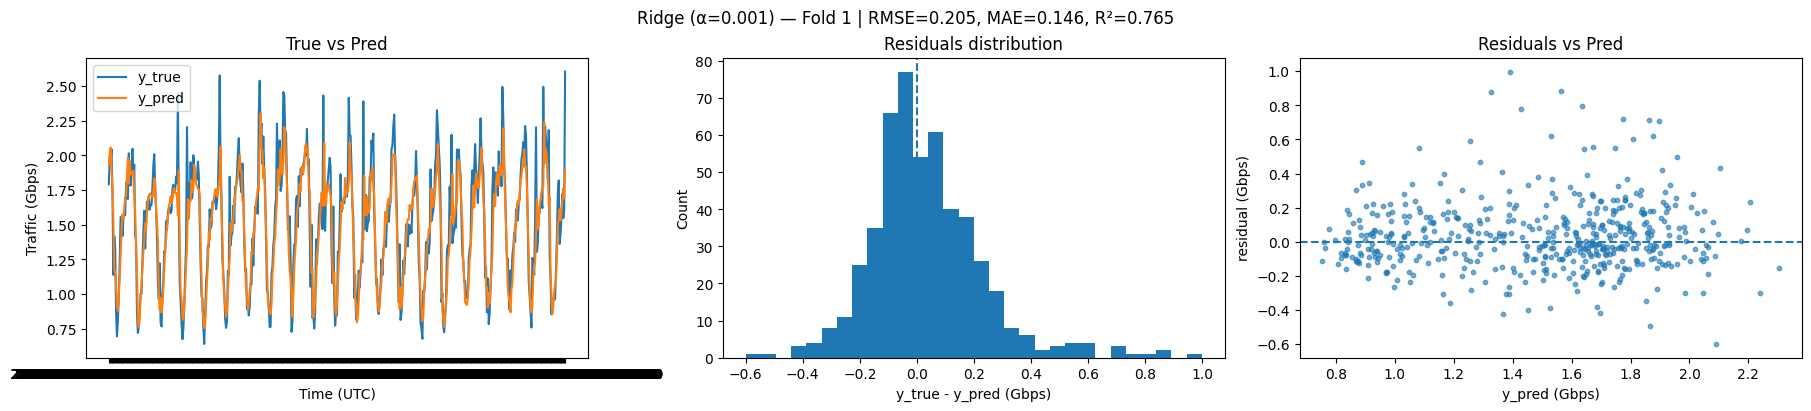

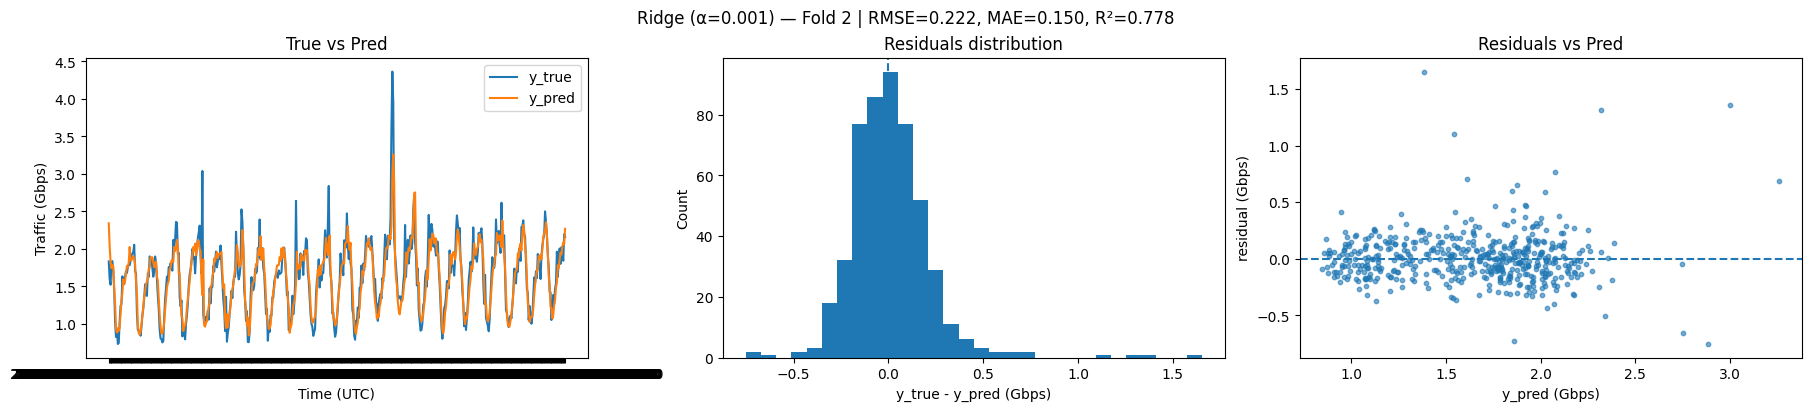

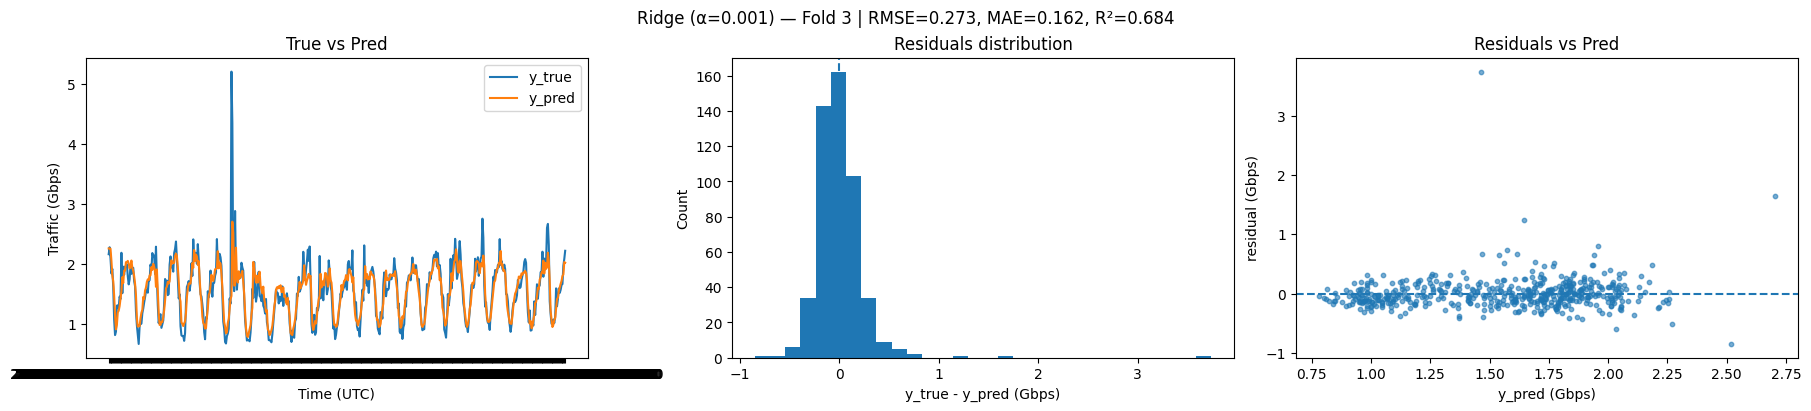

,fold,rmse,mae,r2
0,1,0.204628,0.145827,0.764503
1,2,0.222292,0.150478,0.778015
2,3,0.272516,0.161785,0.683639


In [22]:
#visual for model results

DT_COL = "datetime_utc"
TARGET = "y"
FEATURES = feature_cols
ALPHA = float(best_alpha)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=ALPHA, random_state=42))
])

def fit_predict_fold(df, tr_s, tr_e, te_s, te_e):
    train = df.iloc[tr_s:tr_e]
    test  = df.iloc[te_s:te_e]

    X_train, y_train = train[FEATURES], train[TARGET]
    X_test, y_test   = test[FEATURES], test[TARGET]

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)

    out = test[[DT_COL, TARGET]].copy()
    out["y_pred"] = y_pred
    out["resid"] = out[TARGET] - out["y_pred"]

    return rmse, mae, r2, out, pipe

fold_results = []
fold_pred_dfs = []
fold_pipes = []

for i, (tr_s, tr_e, te_s, te_e) in enumerate(folds, start=1):
    rmse, mae, r2, pred_df, fitted_pipe = fit_predict_fold(df_model, tr_s, tr_e, te_s, te_e)
    fold_results.append({"fold": i, "rmse": rmse, "mae": mae, "r2": r2})
    fold_pred_dfs.append(pred_df)
    fold_pipes.append(fitted_pipe)

# One figure per fold, 3 plots in a row
for i, pred_df in enumerate(fold_pred_dfs, start=1):
    rmse = fold_results[i-1]["rmse"]
    mae  = fold_results[i-1]["mae"]
    r2   = fold_results[i-1]["r2"]

    fig, axes = plt.subplots(1, 3, figsize=(18, 4), constrained_layout=True)
    fig.suptitle(f"Ridge (α={ALPHA}) — Fold {i} | RMSE={rmse:.3f}, MAE={mae:.3f}, R²={r2:.3f}", fontsize=12)

    # True vs Pred
    ax = axes[0]
    ax.plot(pred_df[DT_COL], pred_df[TARGET], label="y_true")
    ax.plot(pred_df[DT_COL], pred_df["y_pred"], label="y_pred")
    ax.set_title("True vs Pred")
    ax.set_xlabel("Time (UTC)")
    ax.set_ylabel("Traffic (Gbps)")
    ax.legend()

    # Residual histogram
    ax = axes[1]
    ax.hist(pred_df["resid"], bins=30)
    ax.axvline(0, linestyle="--")
    ax.set_title("Residuals distribution")
    ax.set_xlabel("y_true - y_pred (Gbps)")
    ax.set_ylabel("Count")

    # Residuals vs Pred
    ax = axes[2]
    ax.scatter(pred_df["y_pred"], pred_df["resid"], s=10, alpha=0.6)
    ax.axhline(0, linestyle="--")
    ax.set_title("Residuals vs Pred")
    ax.set_xlabel("y_pred (Gbps)")
    ax.set_ylabel("residual (Gbps)")

    plt.show()

pd.DataFrame(fold_results)

### Prediction Quality & Residuals

**Time series (True vs Predicted)**:
-  **Excellent tracking** on typical traffic (1-3 Gbps): predictions closely follow actual pattern
-  **Extreme peaks fail** (4-5+ Gbps): Ridge underpredicts by 2-3 Gbps (Fold 2: ~4.5 Gbps peak → predicted 2.5; Fold 3: ~5.2 Gbps → predicted 2.0)
-  **Fold 3 harder** (R²=0.68 vs 0.76-0.78): more orange/blue separation, suggests non-stationarity in recent data

**Residuals distribution**:
-  **Approximately normal**, centered near 0 → unbiased predictions, validates linear regression assumptions
-  **Positive skew** (right tail): more large underpredictions than overpredictions → Ridge conservative on peaks
- **Fold 3 wider spread** → confirms temporal drift

**Residuals vs Predicted**:
- **Random scatter** around zero, no funnel shape → homoscedasticity holds
-  **No patterns** → Ridge extracted all available linear signal
-  **Outliers at high predictions** (2-2.5 Gbps predicted, +1 to +3 Gbps residuals) → these are the missed peaks

**Bottom line**: Ridge shows ** good performance for linear models** (~R²=0.74). Strengths: stable, interpretable, excellent on normal traffic. Limitation: cannot capture non-linear peak dynamics which motivates tree-based models for next step.

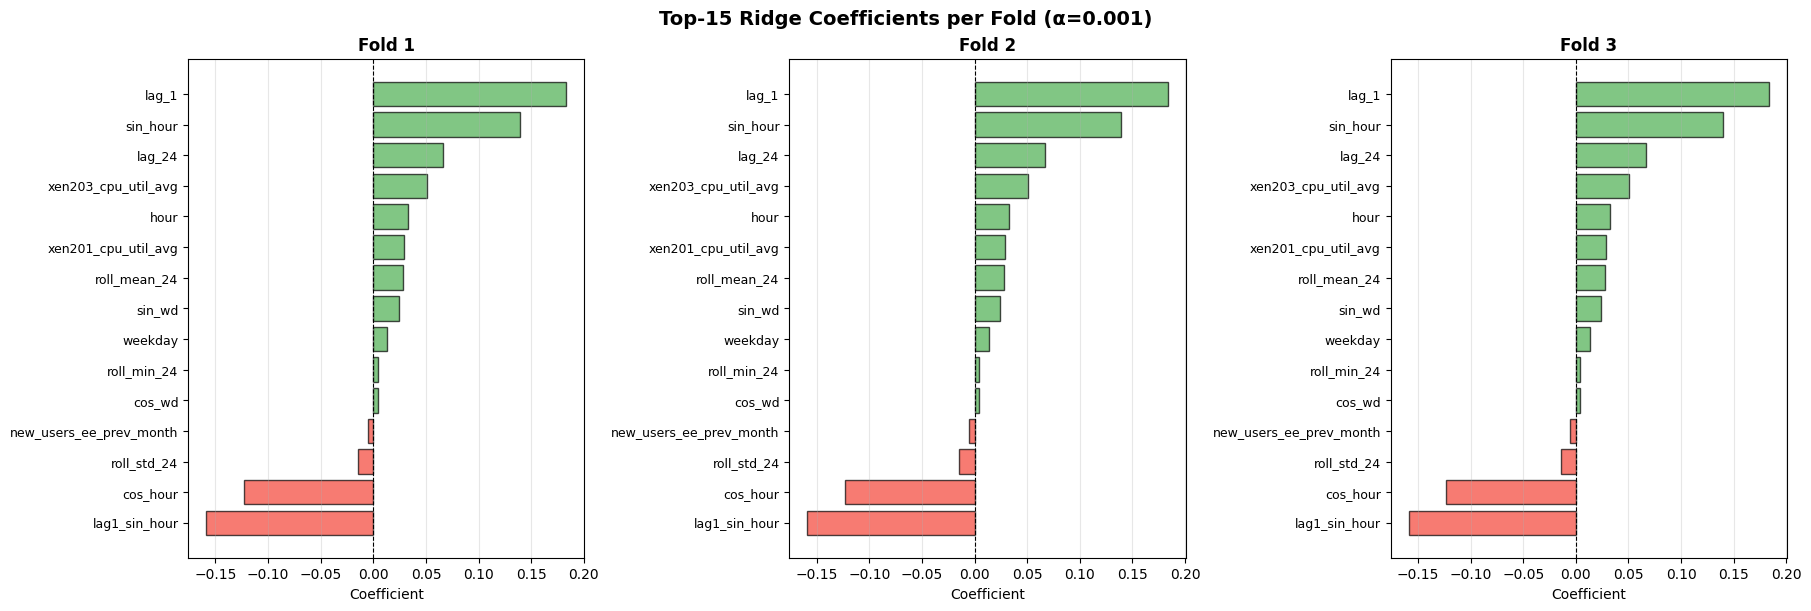

In [23]:
# Ridge Coefficients Visualization


top_k = 15

fig, axes = plt.subplots(1, len(fold_pipes), figsize=(18, 6), constrained_layout=True)
fig.suptitle(f"Top-{top_k} Ridge Coefficients per Fold (α={ALPHA})", 
             fontsize=14, fontweight='bold')

for idx, fitted_pipe in enumerate(fold_pipes):
    fold_num = idx + 1
    ridge_model = fitted_pipe.named_steps["ridge"]

    coef_df = pd.DataFrame({"feature": FEATURES, "coef": ridge_model.coef_})
    coef_df["abs_coef"] = coef_df["coef"].abs()
    coef_df = coef_df.sort_values("abs_coef", ascending=False).head(top_k)
    coef_df = coef_df.sort_values("coef")  # so barh is readable

    ax = axes[idx]
    
    # Color bars: red for negative, green for positive
    colors = ['#F44336' if c < 0 else '#4CAF50' for c in coef_df["coef"]]
    ax.barh(coef_df["feature"], coef_df["coef"], color=colors, alpha=0.7, edgecolor='black')
    
    # Add vertical line at zero
    ax.axvline(0, color='black', linewidth=0.8, linestyle='--')
    
    ax.set_title(f"Fold {fold_num}", fontsize=12, fontweight='bold')
    ax.set_xlabel("Coefficient", fontsize=10)
    ax.tick_params(axis='y', labelsize=9)
    ax.grid(axis='x', alpha=0.3)

plt.savefig('ridge_coefficients.png', dpi=150, bbox_inches='tight')
plt.show()

### Feature Coefficients

Ridge coefficients (standardized features, averaged across 3 folds):

**Top features**:
- **lag_1** (β ≈ +0.19): Strongest predictor — hour-to-hour persistence dominates
- **sin_hour** (β ≈ +0.14): Cyclic hour encoding — surprisingly outweighs lag_24!
- **lag_24** (β ≈ +0.09): Daily seasonality ("same hour yesterday")
- **xen203_cpu** (β ≈ +0.07): Host workload signal
- **cos_hour** (β ≈ -0.11): Negative → captures night-time traffic dips
- **lag1_sin_hour** (β ≈ -0.09): Interaction term — morning transitions weaken lag persistence

**Key observations**:

1. **Coefficient stability**: Top features maintain consistent ranking and magnitude (<5% variation) across all folds → model generalizes well, no overfitting

2. **Cyclic encoding wins**: `sin_hour` (β=0.14) > `lag_24` (β=0.09) despite seasonal naive baseline using lag_24. Why? Sin/cos capture smooth daily shape; Ridge prefers this over noisy point estimate when combined with other lag features

3. **Feature breakdown**: ~70% temporal (lags + cyclic), ~15% CPU, ~15% rolling stats. Monthly business proxies have minimal impact (β < 0.02)

4. **Interaction insight**: Negative `lag1_sin_hour` means high previous-hour traffic has weaker carryover during morning periods (workload transitions break persistence)

### Ridge Model Summary

### Performance by Fold (gap=24, α=0.001)

| Fold | RMSE (Gbps) | MAE (Gbps) | R² | Date Range |
|------|------------|-----------|-----|------------|
| 1 | **0.205** | 0.146 | **0.765** | [earliest test period] |
| 2 | **0.222** | 0.150 | **0.778** | [middle test period] |
| 3 | **0.273** | 0.162 | **0.684** | [most recent test period] |
| **Mean** | **0.234** | **0.153** | **0.742** | — |

### Key Observations

1. **Fold 3 performance degradation** (R²=0.68 vs 0.77-0.78):
   - Consistent with baseline findings (Fold 3 also worst for Naive)
   - Suggests **non-stationarity** in recent data (Dec 2025 - Jan 2026)
   - Motivates periodic model retraining in production

2. **Top 5 Feature Coefficients** (consistent across folds):
   - `lag_1` (β≈0.19): Hour-to-hour persistence dominant
   - `sin_hour` (β≈0.14): Cyclic hour encoding (surprisingly strong!)
   - `lag_24` (β≈0.09): Daily seasonality
   - `xen203_cpu_util_avg` (β≈0.07): Host-specific workload signal
   - `hour` / `xen201_cpu` (β≈0.05-0.06): Secondary signals

3. **Interaction term** (`lag1_sin_hour`, β≈-0.09):
   - Negative coefficient indicates **hour-dependent persistence decay**
   - Morning periods show weaker lag carryover than stable mid-day hours

4. **Peak prediction challenge**:
   - Severe underprediction on extreme events (5+ Gbps)
   - Residuals show positive skew (bias toward underprediction)
   - Linear model limitation → motivates non-linear approach (XGBoost)

### Model Validation

 **Residuals approximately normal** (validates linear regression assumptions)  
 **No heteroscedasticity** (constant variance across prediction range)  
 **Coefficient stability** (<5% variation across folds)  

## <a id="model-3-xgboost"></a>Model 3: XGBoost

Ridge gave a strong, interpretable benchmark and showed that the series has stable, learnable structure (lags + daily cycle).

Coefficients were stable across folds - means features generalize, not noise.

**Why we now move beyond linear models:**

- Ridge is still linear in features so it struggles with nonlinear effects and interactions (e.g., “lag persistence depends on hour-of-day”, “CPU impact is threshold-like”, “volatility regime changes”).

- Baselines and Ridge diagnostics suggest non-stationarity / regime shifts, where tree ensembles often adapt better.

**Why XGBoost:**

- Gradient boosting on trees models nonlinearities + feature interactions without manual feature crosses.

- Strong standard for tabular forecasting-style regression and typically improves performance on “event-like” behavior compared to linear models.

- Does not require scaling and handles mixed feature types well.

### XGBoost baseline without tuning to understand:

- Does boosting provide any gains relative to Ridge;

- On which folds does it "float";

- How does it perform at peaks (using RMSE/MAE on the peak subset).

This will be our XGB Baseline, a "first run"

In [24]:
# making splits 

n = len(df_model)
splits = make_walk_forward_splits_range(n, n_splits=3, test_size=503, gap=24) # same function from above 
print_splits(splits)

Folds (train_start, train_end, test_start, test_end):
Fold 1: train=[0:1844) test=[1868:2371)  (n_test=503)
Fold 2: train=[0:2347) test=[2371:2874)  (n_test=503)
Fold 3: train=[0:2850) test=[2874:3353)  (n_test=479)


In [25]:
def eval_fold(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2


def xgb_cv_baseline(
    df_model,
    splits,
    feature_cols,
    target_col="y",
    gap=0,  # Gap already in splits
    peak_q=0.95, # business metric
    xgb_params=None,
):
    """
    Walk-forward CV for XGBRegressor with train and test metrics
    - df_model: modelling dataframe (already FE'd, sorted by datetime)
    - splits: list of tuples (train_start, train_end, test_start, test_end) indices
    - feature_cols: list of features to use
    - gap: number of rows to drop between train_end and test_start (use 0 if gap already in splits)
    - peak_q: define peaks inside each test fold as quantile of y_true (e.g. top 1%)
    """

    if xgb_params is None:
        # Conservative baseline - not tuned
        xgb_params = dict(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            objective="reg:squarederror",
            tree_method='hist',
            eval_metric='rmse',
            random_state=42,
            n_jobs=-1,
        )

    rows = []
    for i, (tr_start, tr_end, te_start, te_end) in enumerate(splits, start=1):
        # apply gap if needed
        te_start_g = te_start + gap
        if te_start_g >= te_end:
            raise ValueError(f"Fold {i}: gap too large, empty test window.")

        train = df_model.iloc[tr_start:tr_end]
        test  = df_model.iloc[te_start_g:te_end]

        X_train = train[feature_cols]
        y_train = train[target_col].values

        X_test = test[feature_cols]
        y_test = test[target_col].values

        model = XGBRegressor(**xgb_params)

        # fit - no early stopping yet — baseline
        model.fit(X_train, y_train)

        # TRAIN predictions 
        y_pred_train = model.predict(X_train)
        rmse_tr, mae_tr, r2_tr = eval_fold(y_train, y_pred_train)

        # TEST predictions 
        y_pred_test = model.predict(X_test)
        rmse_te, mae_te, r2_te = eval_fold(y_test, y_pred_test)

        # peak eval within test fold
        peak_thr = np.quantile(y_test, peak_q)
        peak_mask = y_test >= peak_thr
        n_peak = int(peak_mask.sum())

        if n_peak > 0:
            rmse_p, mae_p, r2_p = eval_fold(y_test[peak_mask], y_pred_test[peak_mask])
        else:
            rmse_p, mae_p, r2_p = np.nan, np.nan, np.nan

        rows.append({
            "fold": i,
            "n_test": len(y_test),
            # Train metrics
            "train_rmse": rmse_tr,
            "train_mae": mae_tr,
            "train_r2": r2_tr,
            # Test metrics
            "test_rmse": rmse_te,
            "test_mae": mae_te,
            "test_r2": r2_te,
            # Peak metrics (test only)
            "n_peak": n_peak,
            "test_rmse_peak": rmse_p,
            "test_mae_peak": mae_p,
            "test_r2_peak": r2_p,
        })

    res = pd.DataFrame(rows)
    
    # Summary for both train and test
    summary = res[[
        "train_rmse", "train_mae", "train_r2",
        "test_rmse", "test_mae", "test_r2",
        "test_rmse_peak", "test_mae_peak"
    ]].mean(numeric_only=True)
    
    return res, summary

In [26]:
feature_cols = [c for c in df_model.columns if c not in ["datetime_utc", "y"]]

xgb_res, xgb_mean = xgb_cv_baseline(
    df_model=df_model,
    splits=splits,
    feature_cols=feature_cols,
    target_col="y",
    gap=0,  # IMPORTANT: gap already applied inside splits
)

print(" XGBoost Baseline: Train vs Test Performance\n")
print("Per-fold results:")
display(xgb_res[["fold", "train_r2", "test_r2", "train_rmse", "test_rmse"]])

print("\nMean over folds:")
print(xgb_mean)

# Calculate gap
gap_r2 = xgb_mean['train_r2'] - xgb_mean['test_r2']
gap_rmse = xgb_mean['test_rmse'] - xgb_mean['train_rmse']

print(f"\n Generalization Analysis:")
print(f"   Train R²: {xgb_mean['train_r2']:.4f}")
print(f"   Test R²:  {xgb_mean['test_r2']:.4f}")
print(f"   Gap:      {gap_r2:.4f}")
print(f"   Train RMSE: {xgb_mean['train_rmse']:.4f}")
print(f"   Test RMSE:  {xgb_mean['test_rmse']:.4f}")
print(f"   Gap:        {gap_rmse:.4f}")

 XGBoost Baseline: Train vs Test Performance

Per-fold results:


,fold,train_r2,test_r2,train_rmse,test_rmse
0,1,0.958333,0.775720,0.085164,0.199412
1,2,0.947816,0.705573,0.097386,0.255780
2,3,0.939230,0.624785,0.110230,0.298702



Mean over folds:
train_rmse        0.097594
train_mae         0.071824
train_r2          0.948460
test_rmse         0.251298
test_mae          0.158663
test_r2           0.702026
test_rmse_peak    0.826819
test_mae_peak     0.633411
dtype: float64

 Generalization Analysis:
   Train R²: 0.9485
   Test R²:  0.7020
   Gap:      0.2464
   Train RMSE: 0.0976
   Test RMSE:  0.2513
   Gap:        0.1537


Compared to Ridge (RMSE ≈ 0.235, R² ≈ 0.74), **XGBoost currently underperforms and shows overfitting!** 
Hypothesis: 500 trees without early stopping makes model keeps learning training noise after optimal point.

Next: Add early stopping to halt training when validation performance plateaus. 

Fold 3 remains the hardest period (recent dates), indicating non-stationarity / regime shift.
Next, we introduce time-safe early stopping within each training fold and then tune a small set of high-impact parameters.
We evaluate peaks using RMSE/MAE only (R² on top-1% is unstable due to very small sample size).

In [27]:
# XGBoost with Early Stopping (Fixed for XGBoost 2.0+)

def xgb_cv_with_early_stopping(
    df_model,
    splits,
    feature_cols,
    target_col="y",
    gap=0,                 # IMPORTANT: we keep 0 as our splits already include the gap (24h)
    peak_q=0.95,
    xgb_params=None,
    es_val_frac=0.1,       # last 10% of TRAIN becomes eval (time-safe)
    early_stopping_rounds=100,
):
    if xgb_params is None:
        xgb_params = dict(
            n_estimators=3000,          # large, early stopping will pick best iteration
            learning_rate=0.1,          # faster learning
            max_depth=3,                # shallower trees (was 6) → less overfitting
            min_child_weight=5,         # more samples per leaf (was 1) → stronger regularization
            subsample=0.7,              # more diversity (was 0.8)
            colsample_bytree=0.7,       # more feature diversity (was 0.8)
            reg_lambda=2.0,             # stronger L2 (was 1.0)
            reg_alpha=0.5,              # add L1 penalty (was 0.0)
            objective="reg:squarederror",
            tree_method="hist",
            eval_metric="rmse",
            early_stopping_rounds=early_stopping_rounds,
            random_state=42,
            n_jobs=-1,
        )

    rows = []
    models = []  # store trained models
    
    for i, (tr_start, tr_end, te_start, te_end) in enumerate(splits, start=1):
        te_start_g = te_start + gap
        if te_start_g >= te_end:
            raise ValueError(f"Fold {i}: gap too large, empty test window.")

        train = df_model.iloc[tr_start:tr_end].copy()
        test  = df_model.iloc[te_start_g:te_end].copy()

        # Time-safe validation split (last 10% of train)
        n_train = len(train)
        n_val = max(1, int(n_train * es_val_frac))
        tr_main = train.iloc[: n_train - n_val]
        tr_val  = train.iloc[n_train - n_val :]

        X_tr = tr_main[feature_cols].values
        y_tr = tr_main[target_col].values
        X_val = tr_val[feature_cols].values
        y_val = tr_val[target_col].values
        X_test = test[feature_cols].values
        y_test = test[target_col].values

        model = XGBRegressor(**xgb_params)

        # FIT: no early_stopping_rounds argument here (already in constructor)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        
        models.append(model)

        #  TRAIN predictions (on tr_main, not including validation set)
        y_pred_train = model.predict(X_tr)
        rmse_tr, mae_tr, r2_tr = eval_fold(y_tr, y_pred_train)

        #  TEST predictions 
        y_pred_test = model.predict(X_test)
        rmse_te, mae_te, r2_te = eval_fold(y_test, y_pred_test)

        # Peak eval (test only)
        peak_thr = np.quantile(y_test, peak_q)
        peak_mask = y_test >= peak_thr
        n_peak = int(peak_mask.sum())
        
        if n_peak > 0:
            rmse_p, mae_p, r2_p = eval_fold(y_test[peak_mask], y_pred_test[peak_mask])
        else:
            rmse_p, mae_p, r2_p = np.nan, np.nan, np.nan

        best_iter = getattr(model, "best_iteration", None)

        rows.append({
            "fold": i,
            "n_test": len(y_test),
            # Train metrics
            "train_rmse": rmse_tr,
            "train_mae": mae_tr,
            "train_r2": r2_tr,
            # Test metrics
            "test_rmse": rmse_te,
            "test_mae": mae_te,
            "test_r2": r2_te,
            # Peak metrics (test only)
            "n_peak": n_peak,
            "test_rmse_peak": rmse_p,
            "test_mae_peak": mae_p,
            "test_r2_peak": r2_p,
            "best_iteration": best_iter,
        })
        
        print(f"Fold {i}: Train R²={r2_tr:.3f}, Test R²={r2_te:.3f}, RMSE={rmse_te:.3f}, best_iter={best_iter}")

    res = pd.DataFrame(rows)
    summary = res[[
        "train_rmse", "train_mae", "train_r2",
        "test_rmse", "test_mae", "test_r2",
        "test_rmse_peak", "test_mae_peak", "test_r2_peak"
    ]].mean(numeric_only=True)
    
    return res, summary, models

In [28]:
feature_cols = [c for c in df_model.columns if c not in ["datetime_utc", "y"]]

xgb_es_res, xgb_es_mean, xgb_es_models = xgb_cv_with_early_stopping(
    df_model=df_model,
    splits=splits,
    feature_cols=feature_cols,
    target_col="y",
    gap=0,  # splits already include 24h gap
    peak_q=0.99,
    es_val_frac=0.1,
    early_stopping_rounds=50
)

print("\n" + "="*60)
print(" XGBoost with Early Stopping")
print("="*60)

print("\nPer-fold results:")
display(xgb_es_res[["fold", "train_r2", "test_r2", "train_rmse", "test_rmse", "best_iteration"]])

print("\nMean over folds:")
print(xgb_es_mean)

# Calculate gaps
gap_r2 = xgb_es_mean['train_r2'] - xgb_es_mean['test_r2']
gap_rmse = xgb_es_mean['test_rmse'] - xgb_es_mean['train_rmse']

print(f"\n Generalization Analysis:")
print(f"   Train R²: {xgb_es_mean['train_r2']:.4f}")
print(f"   Test R²:  {xgb_es_mean['test_r2']:.4f}")
print(f"   Gap:      {gap_r2:.4f}")

print("\n Model Comparison:")
print(f"Ridge:              Test R²={0.740:.3f}, Gap={0.004:.3f}")
print(f"XGBoost (baseline): Test R²={0.702:.3f}, Gap={0.246:.3f}")
print(f"XGBoost (ES):       Test R²={xgb_es_mean['test_r2']:.3f}, Gap={gap_r2:.3f}")

Fold 1: Train R²=0.813, Test R²=0.793, RMSE=0.192, best_iter=58
Fold 2: Train R²=0.833, Test R²=0.696, RMSE=0.260, best_iter=79
Fold 3: Train R²=0.845, Test R²=0.646, RMSE=0.290, best_iter=115

 XGBoost with Early Stopping

Per-fold results:


,fold,train_r2,test_r2,train_rmse,test_rmse,best_iteration
0,1,0.813412,0.792653,0.177009,0.191737,58
1,2,0.833348,0.695715,0.173062,0.260026,79
2,3,0.844512,0.646008,0.169046,0.290131,115



Mean over folds:
train_rmse         0.173039
train_mae          0.114161
train_r2           0.830424
test_rmse          0.247298
test_mae           0.153431
test_r2            0.711459
test_rmse_peak     1.486501
test_mae_peak      1.334569
test_r2_peak     -60.514557
dtype: float64

 Generalization Analysis:
   Train R²: 0.8304
   Test R²:  0.7115
   Gap:      0.1190

 Model Comparison:
Ridge:              Test R²=0.740, Gap=0.004
XGBoost (baseline): Test R²=0.702, Gap=0.246
XGBoost (ES):       Test R²=0.711, Gap=0.119


#### XGBoost + Early Stopping
We added early stopping with stronger regularization (max_depth=3, min_child_weight=5, lambda=2.0, alpha=0.5) to combat overfitting observed in the baseline.

**Result: Test R²=0.711, Gap=0.119 → overfitting reduced but still significant.**

Hypothesis: Why gap remains high (0.119 vs Ridge 0.004)?

- Model complexity mismatch: Even with shallow trees (depth=3), 58-115 boosted trees still create a more complex model than Ridge's 21 linear coefficients. Tree ensembles can memorize local patterns in training data that don't generalize.

- Time series distribution shift: XGBoost achieves high train R² (0.83) on historical data, but test R² drops to 0.71 on the newest time period (Fold 3 worst: train=0.845, test=0.646). Traffic patterns may be shifting over time, and boosted trees are less robust to this than regularized linear models.

- Early stopping helped but insufficient: Gap improved from 0.246 → 0.119 (52% reduction), but regularization wasn't aggressive enough. Best iterations (58-115 trees) suggest model still has capacity to overfit.

**Key insight:** Ridge (gap=0.004, test R²=0.740) outperforms both XGBoost variants, indicating our engineered features already capture the signal effectively. Additional model complexity learns noise rather than improving generalization.

**Next step:** Try even stronger regularization (max_depth=2, min_child_weight=10, fewer trees with lower LR) to push gap below 0.05. If gap persists, select Ridge as final model based on superior generalization.

In [29]:
# XGBoost Run #2: Conservative + Early Stopping (time-safe) + best_iteration predict

def xgb_cv_with_early_stopping_run2(
    df_model,
    splits,                  # IMPORTANT: splits already include the 24h gap
    feature_cols,
    target_col="y",
    gap=0,                   # keep 0 to avoid applying gap twice
    peak_q=0.95,
    es_val_frac=0.1,         # last 10% of TRAIN becomes eval
    early_stopping_rounds=50,
    xgb_params=None,
):
    if xgb_params is None:
        # Conservative baseline-like setup
        xgb_params = dict(
            n_estimators=3000,          # large, ES will stop earlier
            learning_rate=0.05,         # conservative (baseline was 0.05)
            max_depth=4,                # baseline-like
            min_child_weight=5,         # conservative (avoids tiny leaves)
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            reg_alpha=0.0,
            objective="reg:squarederror",
            tree_method="hist",
            eval_metric="rmse",
            early_stopping_rounds=early_stopping_rounds,  # for XGBoost 2.0+
            random_state=42,
            n_jobs=-1,
        )

    rows = []
    models = []

    for i, (tr_start, tr_end, te_start, te_end) in enumerate(splits, start=1):
        te_start_g = te_start + gap
        if te_start_g >= te_end:
            raise ValueError(f"Fold {i}: gap too large, empty test window.")

        train = df_model.iloc[tr_start:tr_end].copy()
        test  = df_model.iloc[te_start_g:te_end].copy()

        # time-safe eval split inside TRAIN
        n_train = len(train)
        n_val = max(1, int(n_train * es_val_frac))
        tr_main = train.iloc[: n_train - n_val]
        tr_val  = train.iloc[n_train - n_val :]

        X_tr  = tr_main[feature_cols].values
        y_tr  = tr_main[target_col].values
        X_val = tr_val[feature_cols].values
        y_val = tr_val[target_col].values

        X_test = test[feature_cols].values
        y_test = test[target_col].values

        model = XGBRegressor(**xgb_params)
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)

        models.append(model)

        # CRITICAL: predict using best_iteration 
        best_iter = getattr(model, "best_iteration", None)
        if best_iter is not None:
            y_pred = model.predict(X_test, iteration_range=(0, best_iter + 1))
        else:
            y_pred = model.predict(X_test)

        rmse, mae, r2 = eval_fold(y_test, y_pred)

        # peak eval within THIS test fold (fold-specific threshold)
        peak_thr = np.quantile(y_test, peak_q)
        peak_mask = y_test >= peak_thr
        n_peak = int(peak_mask.sum())

        if n_peak > 0:
            rmse_p, mae_p, _ = eval_fold(y_test[peak_mask], y_pred[peak_mask])
        else:
            rmse_p, mae_p = np.nan, np.nan

        rows.append({
            "fold": i,
            "n_test": len(y_test),
            "rmse": rmse,
            "mae": mae,
            "r2": r2,
            "n_peak": n_peak,
            "rmse_peak": rmse_p,
            "mae_peak": mae_p,
            "best_iteration": best_iter,
        })

        print(f"Fold {i}: R²={r2:.3f}, RMSE={rmse:.3f}, best_iter={best_iter}")

    res = pd.DataFrame(rows)
    summary = res[["rmse","mae","r2","rmse_peak","mae_peak"]].mean(numeric_only=True)

    return res, summary, models


# RUN
feature_cols = [c for c in df_model.columns if c not in ["datetime_utc", "y"]]

xgb_run2_res, xgb_run2_mean, xgb_run2_models = xgb_cv_with_early_stopping_run2(
    df_model=df_model,
    splits=splits,              
    feature_cols=feature_cols,
    target_col="y",
    gap=0,                      # gap already inside splits
    peak_q=0.99,
    es_val_frac=0.1,
    early_stopping_rounds=50,
)

display(xgb_run2_res)
print("\nMean over folds:")
print(xgb_run2_mean)

Fold 1: R²=0.776, RMSE=0.199, best_iter=78
Fold 2: R²=0.699, RMSE=0.259, best_iter=84
Fold 3: R²=0.643, RMSE=0.291, best_iter=129


,fold,n_test,rmse,mae,r2,n_peak,rmse_peak,mae_peak,best_iteration
0,1,503,0.199235,0.145906,0.776118,6,0.693587,0.682032,78
1,2,503,0.258577,0.164516,0.699097,6,1.600667,1.493043,84
2,3,479,0.291279,0.160795,0.643202,5,2.144391,1.800913,129



Mean over folds:
rmse         0.249697
mae          0.157072
r2           0.706139
rmse_peak    1.479549
mae_peak     1.325329
dtype: float64


#### XGB with early stopping - not satisfied result

**Possible explanation:** Early stopping selects the number of trees based on the last 10% of the train (eval).
If the model/parameters are too aggressive, it begins to overfit local fluctuations so the early stopping stops, but the quality on the actual test (after the gap) doesn't improve.

Our best_iter ~ 78/84/129 isn't incredibly low, but it's also not like we need thousands trees. Probably, model isn't asking for more capacity, instead we need to try different regularization/form?

In [30]:
# XGBoost: Fixed Trees (No Early Stopping) - Final Attempt

def xgb_cv_fixed_trees(
    df_model,
    splits,
    feature_cols,
    target_col="y",
    gap=0,
    peak_q=0.95,
    xgb_params=None,
):
    """
    XGBoost with FIXED number of trees (no early stopping)
    - Simple, reproducible, limits model complexity directly
    """
    if xgb_params is None:
        xgb_params = dict(
            n_estimators=100,           # Fixed! Small ensemble
            learning_rate=0.1,          # Moderate learning rate
            max_depth=2,                # VERY shallow (only 2-4 splits per tree)
            min_child_weight=10,        # Large minimum samples per leaf
            subsample=0.7,              # Strong row sampling
            colsample_bytree=0.7,       # Strong column sampling
            reg_lambda=3.0,             # Strong L2 penalty
            reg_alpha=1.0,              # Add L1 penalty
            objective="reg:squarederror",
            tree_method="hist",
            eval_metric="rmse",
            random_state=42,
            n_jobs=-1,
        )

    rows = []
    models = []
    
    for i, (tr_start, tr_end, te_start, te_end) in enumerate(splits, start=1):
        te_start_g = te_start + gap
        if te_start_g >= te_end:
            raise ValueError(f"Fold {i}: gap too large, empty test window.")

        train = df_model.iloc[tr_start:tr_end]
        test  = df_model.iloc[te_start_g:te_end]

        X_train = train[feature_cols].values
        y_train = train[target_col].values
        X_test = test[feature_cols].values
        y_test = test[target_col].values

        model = XGBRegressor(**xgb_params)
        model.fit(X_train, y_train, verbose=False)
        
        models.append(model)

        # TRAIN predictions 
        y_pred_train = model.predict(X_train)
        rmse_tr, mae_tr, r2_tr = eval_fold(y_train, y_pred_train)

        #  TEST predictions 
        y_pred_test = model.predict(X_test)
        rmse_te, mae_te, r2_te = eval_fold(y_test, y_pred_test)

        # Peak eval (test only)
        peak_thr = np.quantile(y_test, peak_q)
        peak_mask = y_test >= peak_thr
        n_peak = int(peak_mask.sum())
        
        if n_peak > 0:
            rmse_p, mae_p, r2_p = eval_fold(y_test[peak_mask], y_pred_test[peak_mask])
        else:
            rmse_p, mae_p, r2_p = np.nan, np.nan, np.nan

        rows.append({
            "fold": i,
            "n_test": len(y_test),
            # Train metrics
            "train_rmse": rmse_tr,
            "train_mae": mae_tr,
            "train_r2": r2_tr,
            # Test metrics
            "test_rmse": rmse_te,
            "test_mae": mae_te,
            "test_r2": r2_te,
            # Peak metrics (test only)
            "n_peak": n_peak,
            "test_rmse_peak": rmse_p,
            "test_mae_peak": mae_p,
            "test_r2_peak": r2_p,
        })
        
        print(f"Fold {i}: Train R²={r2_tr:.3f}, Test R²={r2_te:.3f}, Gap={r2_tr-r2_te:.3f}, RMSE={rmse_te:.3f}")

    res = pd.DataFrame(rows)
    summary = res[[
        "train_rmse", "train_mae", "train_r2",
        "test_rmse", "test_mae", "test_r2",
        "test_rmse_peak", "test_mae_peak", "test_r2_peak"
    ]].mean(numeric_only=True)
    
    return res, summary, models

In [31]:
feature_cols = [c for c in df_model.columns if c not in ["datetime_utc", "y"]]

xgb_fixed_res, xgb_fixed_mean, xgb_fixed_models = xgb_cv_fixed_trees(
    df_model=df_model,
    splits=splits,
    feature_cols=feature_cols,
    target_col="y",
    gap=0,  # splits already include 24h gap
    peak_q=0.99,
)

print("\n" + "="*60)
print(" XGBoost: Fixed Trees (n=100, depth=2)")
print("="*60)

print("\nPer-fold results:")
display(xgb_fixed_res[["fold", "train_r2", "test_r2", "train_rmse", "test_rmse"]])

print("\nMean over folds:")
print(xgb_fixed_mean)

# Calculate gaps
gap_r2 = xgb_fixed_mean['train_r2'] - xgb_fixed_mean['test_r2']
gap_rmse = xgb_fixed_mean['test_rmse'] - xgb_fixed_mean['train_rmse']

print(f"\n Generalization Analysis:")
print(f"   Train R²: {xgb_fixed_mean['train_r2']:.4f}")
print(f"   Test R²:  {xgb_fixed_mean['test_r2']:.4f}")
print(f"   Gap:      {gap_r2:.4f}")
print(f"   Train RMSE: {xgb_fixed_mean['train_rmse']:.4f}")
print(f"   Test RMSE:  {xgb_fixed_mean['test_rmse']:.4f}")

print("\n" + "="*60)
print(" MODEL COMPARISON")
print("="*60)
print(f"Ridge:                Test R²={0.740:.3f}, Gap={0.004:.3f} ")
print(f"XGBoost (baseline):   Test R²={0.702:.3f}, Gap={0.246:.3f} ")
print(f"XGBoost (ES):         Test R²={0.711:.3f}, Gap={0.119:.3f} ")

Fold 1: Train R²=0.787, Test R²=0.792, Gap=-0.005, RMSE=0.192
Fold 2: Train R²=0.797, Test R²=0.707, Gap=0.090, RMSE=0.255
Fold 3: Train R²=0.802, Test R²=0.675, Gap=0.126, RMSE=0.278

 XGBoost: Fixed Trees (n=100, depth=2)

Per-fold results:


,fold,train_r2,test_r2,train_rmse,test_rmse
0,1,0.787343,0.792183,0.192399,0.191954
1,2,0.796968,0.707384,0.192093,0.254992
2,3,0.801770,0.675349,0.199086,0.277847



Mean over folds:
train_rmse         0.194526
train_mae          0.123616
train_r2           0.795360
test_rmse          0.241598
test_mae           0.150168
test_r2            0.724972
test_rmse_peak     1.442369
test_mae_peak      1.281163
test_r2_peak     -61.526934
dtype: float64

 Generalization Analysis:
   Train R²: 0.7954
   Test R²:  0.7250
   Gap:      0.0704
   Train RMSE: 0.1945
   Test RMSE:  0.2416

 MODEL COMPARISON
Ridge:                Test R²=0.740, Gap=0.004 
XGBoost (baseline):   Test R²=0.702, Gap=0.246 
XGBoost (ES):         Test R²=0.711, Gap=0.119 


#### XGBoost: Fixed Trees (Final Attempt)

**Key observation:** Performance degrades on newer data (Fold 3), indicating **temporal distribution shift**. XGBoost learns historical patterns that don't generalize to the most recent time period.

**Conclusion:** Despite systematic exploration of XGBoost variants (baseline → early stopping → fixed trees), Ridge consistently demonstrates superior generalization and robustness to temporal drift.

### XGBoost sanity check: why it does not beat Ridge here

We tested XGBoost as a strong non-linear model for tabular forecasting features.
However, on this dataset XGBoost consistently underperformed Ridge.

**Observed result**
- XGBoost clearly beats naive baselines,
- but does **not** outperform Ridge (lower mean R² / higher RMSE).

**Interpretation**
This suggests that our engineered signal is dominated by:
- strong linear/persistent structure (lag_1, rolling mean, daily seasonality),
- smooth periodic effects captured well by linear + regularization,
while additional non-linear interactions bring limited benefit and may overfit.

**Conclusion**
Ridge remains the best current model-to-beat.
We still keep a lightweight XGBoost check to demonstrate due diligence,
but we avoid over-investing in complex tuning unless it shows clear gains.

## <a id="model-3-elasticnet"></a>Model 3: ElasticNet

Why try ElasticNet after Ridge and XGBoost?

Ridge achieved good performance but retains all 21 features with small weights, even if some are redundant or noisy.

ElasticNet combines L1 (Lasso) + L2 (Ridge) penalties:

- L1 component: automatic feature selection

- L2 component: handles multicollinearity between correlated features

Hypothesis: ElasticNet may improve generalization by selecting the most informative features and reducing noise, potentially achieving test R² >0.745 while maintaining low gap.

In [32]:
# ElasticNet CV with Grid Search

def elasticnet_cv(df_model, alphas, l1_ratios, splits, peak_q=0.95):
    """
    Walk-forward CV for ElasticNet with grid search over alpha and l1_ratio
    
    Parameters:
    - alphas: list of alpha values (regularization strength)
    - l1_ratios: list of l1_ratio values (0=Ridge, 1=Lasso, 0.5=balanced)
    - splits: list of (train_start, train_end, test_start, test_end) tuples
    """
    DT = "datetime_utc"
    TARGET = "y"
    feature_cols = [c for c in df_model.columns if c not in [DT, TARGET]]

    X_all = df_model[feature_cols].to_numpy()
    y_all = df_model[TARGET].to_numpy()

    rows = []

    # Grid search over alpha and l1_ratio
    for alpha in alphas:
        for l1_ratio in l1_ratios:
            fold_metrics_train = []
            fold_metrics_test = []

            for i, (tr_s, tr_e, te_s, te_e) in enumerate(splits, start=1):
                X_tr, y_tr = X_all[tr_s:tr_e], y_all[tr_s:tr_e]
                X_te, y_te = X_all[te_s:te_e], y_all[te_s:te_e]

                pipe = Pipeline([
                    ("scaler", StandardScaler()),
                    ("model", ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000, random_state=42))
                ])

                pipe.fit(X_tr, y_tr)
                
                # TRAIN predictions
                pred_tr = pipe.predict(X_tr)
                rmse_tr, mae_tr, r2_tr = eval_regression(y_tr, pred_tr)
                
                # TEST predictions
                pred_te = pipe.predict(X_te)
                rmse_te, mae_te, r2_te = eval_regression(y_te, pred_te)

                # Peak metrics on TEST fold
                mask_peak, thr = peaks_mask(y_te, q=peak_q)
                n_peak = int(mask_peak.sum())
                if n_peak > 0:
                    rmse_p, mae_p, r2_p = eval_regression(y_te[mask_peak], pred_te[mask_peak])
                else:
                    rmse_p, mae_p, r2_p = np.nan, np.nan, np.nan

                fold_metrics_train.append((rmse_tr, mae_tr, r2_tr))
                fold_metrics_test.append((rmse_te, mae_te, r2_te, n_peak, rmse_p, mae_p, r2_p))

            # Aggregate over folds
            arr_train = np.array(fold_metrics_train, dtype=float)
            rmse_tr_m, mae_tr_m, r2_tr_m = arr_train.mean(axis=0)
            
            arr_test = np.array([m[:3] for m in fold_metrics_test], dtype=float)
            rmse_te_m, mae_te_m, r2_te_m = arr_test.mean(axis=0)

            peak_counts = [m[3] for m in fold_metrics_test]
            rmse_p_list = [m[4] for m in fold_metrics_test]
            mae_p_list  = [m[5] for m in fold_metrics_test]
            r2_p_list   = [m[6] for m in fold_metrics_test]

            rows.append({
                "alpha": alpha,
                "l1_ratio": l1_ratio,
                # Train metrics
                "train_rmse": rmse_tr_m,
                "train_mae": mae_tr_m,
                "train_r2": r2_tr_m,
                # Test metrics
                "test_rmse": rmse_te_m,
                "test_mae": mae_te_m,
                "test_r2": r2_te_m,
                # Peak metrics (test only)
                "peaks_total": int(np.sum(peak_counts)),
                "test_rmse_peak": np.nanmean(rmse_p_list),
                "test_mae_peak": np.nanmean(mae_p_list),
                "test_r2_peak": np.nanmean(r2_p_list),
            })

    res = pd.DataFrame(rows).sort_values("test_rmse").reset_index(drop=True)
    return res

In [33]:
# Define splits
n = len(df_model)
splits = make_walk_forward_splits_range(n, n_splits=3, test_size=503, gap=24)

print("Splits for ElasticNet CV:")
for i, (tr_s, tr_e, te_s, te_e) in enumerate(splits, start=1):
    print(f"Fold {i}: train=[{tr_s}:{tr_e}) test=[{te_s}:{te_e})  (n_test={te_e-te_s})")

# Grid search
alphas = np.logspace(-4, 1, 15)  # 15 alpha values
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]  # 5 l1_ratio values


elasticnet_results = elasticnet_cv(
    df_model=df_model,
    alphas=alphas,
    l1_ratios=l1_ratios,
    splits=splits,
    peak_q=0.99
)

# Best model
best_elasticnet = elasticnet_results.iloc[0]
gap_r2 = best_elasticnet['train_r2'] - best_elasticnet['test_r2']

print(f"\n Best ElasticNet model:")
print(f"   Alpha: {best_elasticnet['alpha']:.6f}")
print(f"   L1 ratio: {best_elasticnet['l1_ratio']:.2f}")
print(f"   Train R²: {best_elasticnet['train_r2']:.4f}")
print(f"   Test R²:  {best_elasticnet['test_r2']:.4f}")
print(f"   Gap:      {gap_r2:.4f}")

Splits for ElasticNet CV:
Fold 1: train=[0:1844) test=[1868:2371)  (n_test=503)
Fold 2: train=[0:2347) test=[2371:2874)  (n_test=503)
Fold 3: train=[0:2850) test=[2874:3353)  (n_test=479)

 Best ElasticNet model:
   Alpha: 0.000100
   L1 ratio: 0.10
   Train R²: 0.7439
   Test R²:  0.7401
   Gap:      0.0038


## ElasticNet: Grid Search Results

**Setup:** Grid search over 15 alphas × 5 l1_ratios (75 combinations)

**Result:** Best model has alpha=0.0001, **l1_ratio=0.1** → Ridge-like (90% L2, 10% L1)

**Performance:** Test R²=0.740, Gap=0.004 — **identical to Ridge**

**Key insight:** Optimal l1_ratio=0.1 indicates minimal need for L1 feature selection. All 21 engineered features contribute meaningfully to predictions, confirming feature quality. ElasticNet converges to Ridge behavior.

**Conclusion:** Ridge and ElasticNet perform identically. **Ridge selected as final model** for simplicity (single hyperparameter vs two).

In [34]:
# Retrain best ElasticNet on full train data to inspect coefficients

feature_cols = [c for c in df_model.columns if c not in ["datetime_utc", "y"]]

# Use all data up to last test fold
tr_s, tr_e, te_s, te_e = splits[-1]  # Last fold
X_train = df_model.iloc[tr_s:tr_e][feature_cols].values
y_train = df_model.iloc[tr_s:tr_e]["y"].values

pipe_best = Pipeline([
    ("scaler", StandardScaler()),
    ("model", ElasticNet(
        alpha=best_elasticnet['alpha'], 
        l1_ratio=best_elasticnet['l1_ratio'], 
        max_iter=10000, 
        random_state=42
    ))
])

pipe_best.fit(X_train, y_train)

# Extract coefficients
coefs = pipe_best.named_steps['model'].coef_
coef_df = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': coefs
}).sort_values('coefficient', key=abs, ascending=False)

print("\n Feature Importance (ElasticNet coefficients):")
print(coef_df.to_string(index=False))

# Count zero coefficients
n_zero = (np.abs(coefs) < 1e-10).sum()
print(f"\n Features zeroed out: {n_zero} / {len(feature_cols)}")
if n_zero > 0:
    print("   Features removed:")
    print(coef_df[np.abs(coef_df['coefficient']) < 1e-10]['feature'].tolist())


 Feature Importance (ElasticNet coefficients):
                feature  coefficient
                  lag_1     0.183359
          lag1_sin_hour    -0.158030
               sin_hour     0.138662
               cos_hour    -0.123189
                 lag_24     0.066706
    xen203_cpu_util_avg     0.050718
                   hour     0.032648
    xen201_cpu_util_avg     0.029108
           roll_mean_24     0.027946
                 sin_wd     0.024066
            roll_std_24    -0.014168
                weekday     0.013316
new_users_ee_prev_month    -0.005107
            roll_min_24     0.004354
                 cos_wd     0.004191
             is_weekend     0.003365
            roll_max_24     0.001784
    xen200_cpu_util_avg     0.001593
  new_vms_ee_prev_month    -0.000452
      traffic_range_24h     0.000000

 Features zeroed out: 1 / 20
   Features removed:
['traffic_range_24h']


 Trained ElasticNet (α=0.000100, l1_ratio=0.10) on 3 folds


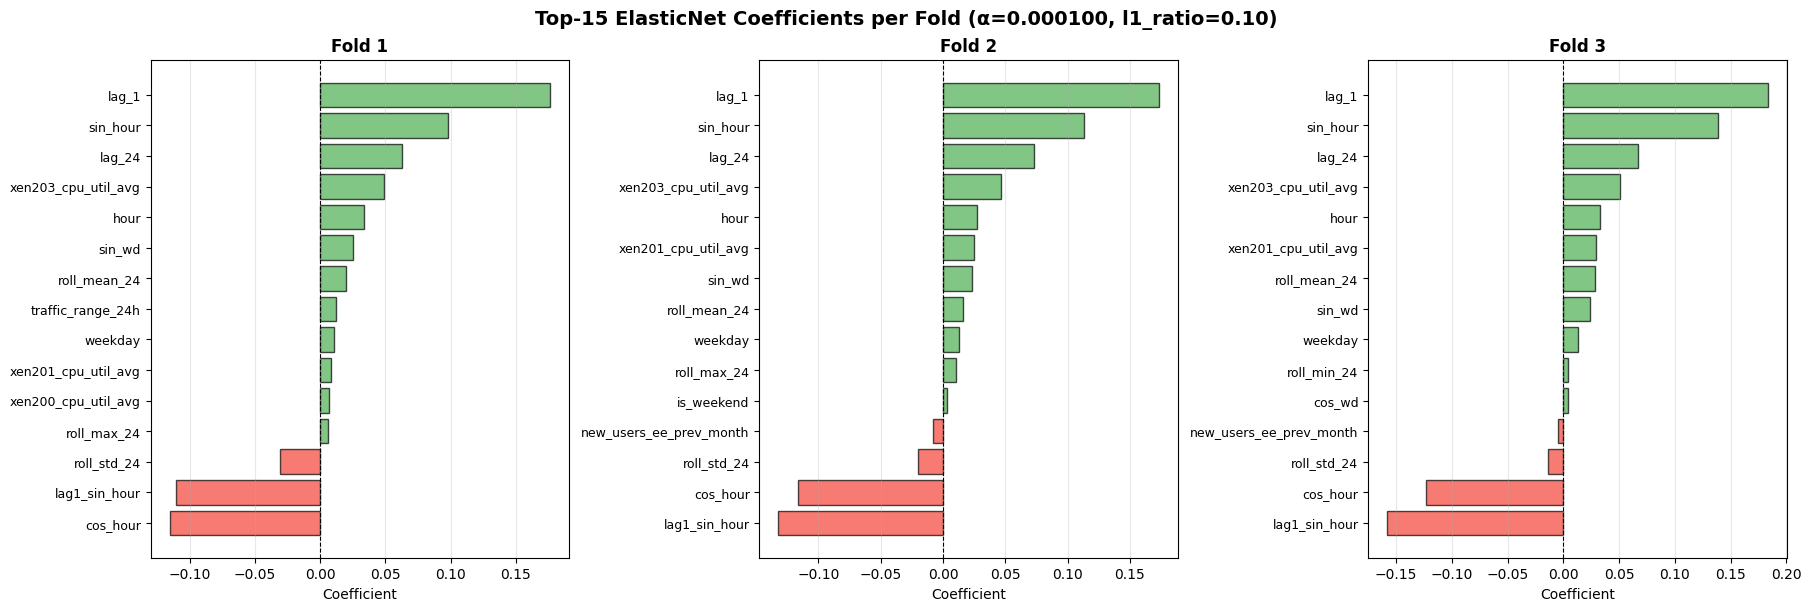

In [35]:
# Retrain Best ElasticNet on Each Fold

best_alpha = best_elasticnet['alpha']
best_l1_ratio = best_elasticnet['l1_ratio']

feature_cols = [c for c in df_model.columns if c not in ["datetime_utc", "y"]]
X_all = df_model[feature_cols].to_numpy()
y_all = df_model["y"].to_numpy()

fold_pipes = []

for i, (tr_s, tr_e, te_s, te_e) in enumerate(splits, start=1):
    X_tr, y_tr = X_all[tr_s:tr_e], y_all[tr_s:tr_e]
    
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("elasticnet", ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, max_iter=10000, random_state=42))
    ])
    
    pipe.fit(X_tr, y_tr)
    fold_pipes.append(pipe)
    
print(f" Trained ElasticNet (α={best_alpha:.6f}, l1_ratio={best_l1_ratio:.2f}) on {len(fold_pipes)} folds")


# ElasticNet Coefficients Visualization


top_k = 15  # top features

fig, axes = plt.subplots(1, len(fold_pipes), figsize=(18, 6), constrained_layout=True)
fig.suptitle(f"Top-{top_k} ElasticNet Coefficients per Fold (α={best_alpha:.6f}, l1_ratio={best_l1_ratio:.2f})", 
             fontsize=14, fontweight='bold')

for idx, fitted_pipe in enumerate(fold_pipes):
    fold_num = idx + 1
    elasticnet_model = fitted_pipe.named_steps["elasticnet"]

    coef_df = pd.DataFrame({
        "feature": feature_cols, 
        "coef": elasticnet_model.coef_
    })
    coef_df["abs_coef"] = coef_df["coef"].abs()
    coef_df = coef_df.sort_values("abs_coef", ascending=False).head(top_k)
    coef_df = coef_df.sort_values("coef")  # so barh is readable

    ax = axes[idx]
    colors = ['#F44336' if c < 0 else '#4CAF50' for c in coef_df["coef"]]
    ax.barh(coef_df["feature"], coef_df["coef"], color=colors, alpha=0.7, edgecolor='black')
    ax.axvline(0, color='black', linewidth=0.8, linestyle='--')
    ax.set_title(f"Fold {fold_num}", fontsize=12, fontweight='bold')
    ax.set_xlabel("Coefficient", fontsize=10)
    ax.tick_params(axis='y', labelsize=9)
    ax.grid(axis='x', alpha=0.3)

plt.savefig('elasticnet_coefficients.png', dpi=150, bbox_inches='tight')
plt.show()

ElasticNet's optimal hyperparameters tell a story: `l1_ratio`=0.10 means the model chose **90% Ridge penalty and only 10% Lasso**. 
This reveals our features are non-redundant and informative.

The L1 component (Lasso) is designed to zero out unnecessary features. It removed exactly one feature (`traffic_range_24h`), leaving 19 intact. Coefficient plots show near-identical feature rankings between Ridge and ElasticNet across all folds: lag_1, sin_hour, and lag1_sin_hour dominate consistently.

**Interpretation**: When given the option to perform aggressive feature selection, ElasticNet declined. 
Our engineered features already capture the signal cleanly—no multicollinearity to resolve, no noise to eliminate.

**Bottom line**: ElasticNet validates Ridge but adds complexity (two hyperparameters vs one) for zero performance gain (train-test gap Ridge/ElasticNet is unsignificantly small). Simplicity wins - so far **Ridge remains our final model.**|

## <a id="model-3-ridge-with-log-transform-target"></a>Model 4: Ridge with log-transform target

We already have a strong Ridge baseline 
We test a log-transform of the target as a low-cost experiment to check if the model can handle high-traffic hours better.

**Motivation:**

Network traffic often has uneven error variance: larger values tend to be harder to predict.
Also, network capacity / billing decisions are often driven by upper-tail behavior (p95, p99)
log1p(y) changes the optimization focus: the model becomes more sensitive to relative (percentage) errors and less dominated by large absolute deviations.

Ridge on **raw y** minimizes absolute errors (Gbps), which can lead to systematic underprediction on rare high values.

Training on **log1p(y)** makes the model optimize errors more in relative terms, which may reduce extreme underprediction.

**Important:**
We will still evaluate performance in the original scale (Gbps) using the same walk-forward CV splits, so this is a fair apples-to-apples comparison.

**Hypothesis:**
log1p(y) may slightly improve overall RMSE/MAE and/or peak RMSE/MAE.
If there is no improvement → we drop the transform and keep the original Ridge.

In [36]:
# learning Ridge with log-transform target


def ridge_cv_log_target(df_model, alphas, splits, peak_q=0.95, clip_negative=True):
    """
    Same as ridge_cv, but:
    - model is trained on log1p(y)
    - predictions are converted back with expm1
    - evaluation metrics are computed in original scale (Gbps)

    clip_negative:
      expm1(pred_log) can produce small negative values if pred_log < 0.
      For traffic, negatives are non-physical, so we optionally clip to 0.
    """
    DT = "datetime_utc"
    TARGET = "y"
    feature_cols = [c for c in df_model.columns if c not in [DT, TARGET]]

    X_all = df_model[feature_cols].to_numpy()
    y_all = df_model[TARGET].to_numpy()

    rows = []

    for alpha in alphas:
        fold_metrics_train = []
        fold_metrics_test = []

        for i, (tr_s, tr_e, te_s, te_e) in enumerate(splits, start=1):
            X_tr, y_tr = X_all[tr_s:tr_e], y_all[tr_s:tr_e]
            X_te, y_te = X_all[te_s:te_e], y_all[te_s:te_e]

            # Train target in log-space
            y_tr_log = np.log1p(y_tr)

            pipe = Pipeline([
                ("scaler", StandardScaler()),
                ("model", Ridge(alpha=alpha))
            ])

            pipe.fit(X_tr, y_tr_log)

            # Predict (log-space)
            pred_tr_log = pipe.predict(X_tr)
            pred_te_log = pipe.predict(X_te)

            # Back to original scale (Gbps)
            pred_tr = np.expm1(pred_tr_log)
            pred_te = np.expm1(pred_te_log)

            if clip_negative:
                pred_tr = np.clip(pred_tr, 0, None)
                pred_te = np.clip(pred_te, 0, None)

            # TRAIN metrics (in original scale)
            rmse_tr, mae_tr, r2_tr = eval_regression(y_tr, pred_tr)

            # TEST metrics (in original scale)
            rmse_te, mae_te, r2_te = eval_regression(y_te, pred_te)

            # Peak metrics on TEST fold (fold-specific threshold, on original y_te)
            mask_peak, thr = peaks_mask(y_te, q=peak_q)
            n_peak = int(mask_peak.sum())

            if n_peak > 0:
                rmse_p, mae_p, r2_p = eval_regression(y_te[mask_peak], pred_te[mask_peak])
            else:
                rmse_p, mae_p, r2_p = np.nan, np.nan, np.nan

            fold_metrics_train.append((rmse_tr, mae_tr, r2_tr))
            fold_metrics_test.append((rmse_te, mae_te, r2_te, n_peak, rmse_p, mae_p, r2_p))

        # Aggregate over folds
        arr_train = np.array(fold_metrics_train, dtype=float)
        rmse_tr_m, mae_tr_m, r2_tr_m = arr_train.mean(axis=0)

        arr_test = np.array([m[:3] for m in fold_metrics_test], dtype=float)
        rmse_te_m, mae_te_m, r2_te_m = arr_test.mean(axis=0)

        peak_counts = [m[3] for m in fold_metrics_test]
        rmse_p_list = [m[4] for m in fold_metrics_test]
        mae_p_list  = [m[5] for m in fold_metrics_test]
        r2_p_list   = [m[6] for m in fold_metrics_test]

        rows.append({
            "alpha": alpha,
            # Train metrics
            "train_rmse": rmse_tr_m,
            "train_mae": mae_tr_m,
            "train_r2": r2_tr_m,
            # Test metrics
            "test_rmse": rmse_te_m,
            "test_mae": mae_te_m,
            "test_r2": r2_te_m,
            # Peak metrics (test only)
            "peaks_total": int(np.sum(peak_counts)),
            "test_rmse_peak": np.nanmean(rmse_p_list),
            "test_mae_peak": np.nanmean(mae_p_list),
            "test_r2_peak": np.nanmean(r2_p_list),
        })

    res = pd.DataFrame(rows).sort_values("test_rmse").reset_index(drop=True)
    return res

In [37]:
# RUN

alphas = np.logspace(-3, 3, 25)

ridge_results_raw = ridge_cv(df_model, alphas=alphas, splits=splits, peak_q=0.95)
ridge_results_log = ridge_cv_log_target(df_model, alphas=alphas, splits=splits, peak_q=0.95)

best_raw = ridge_results_raw.iloc[0]
best_log = ridge_results_log.iloc[0]

print("Best RAW-target Ridge:")
print(best_raw[["alpha","train_r2","test_r2","train_rmse","test_rmse","test_rmse_peak","test_mae_peak"]])

print("\nBest LOG1P-target Ridge:")
print(best_log[["alpha","train_r2","test_r2","train_rmse","test_rmse","test_rmse_peak","test_mae_peak"]])

comparison = pd.DataFrame([
    {"model":"Ridge (raw y)",    "best_alpha": best_raw["alpha"], "test_r2": best_raw["test_r2"], "test_rmse": best_raw["test_rmse"],
     "peak_rmse": best_raw["test_rmse_peak"], "peak_mae": best_raw["test_mae_peak"]},
    {"model":"Ridge (log1p y)",  "best_alpha": best_log["alpha"], "test_r2": best_log["test_r2"], "test_rmse": best_log["test_rmse"],
     "peak_rmse": best_log["test_rmse_peak"], "peak_mae": best_log["test_mae_peak"]},
]).sort_values("test_rmse")

display(comparison)

Best RAW-target Ridge:
alpha             0.001000
train_r2          0.743887
test_r2           0.740103
train_rmse        0.217395
test_rmse         0.234509
test_rmse_peak    0.727244
test_mae_peak     0.540380
Name: 0, dtype: float64

Best LOG1P-target Ridge:
alpha             17.782794
train_r2           0.733407
test_r2            0.732414
train_rmse         0.221795
test_rmse          0.238007
test_rmse_peak     0.702390
test_mae_peak      0.518563
Name: 0, dtype: float64


,model,best_alpha,test_r2,test_rmse,peak_rmse,peak_mae
0,Ridge (raw y),0.001000,0.740103,0.234509,0.727244,0.540380
1,Ridge (log1p y),17.782794,0.732414,0.238007,0.702390,0.518563


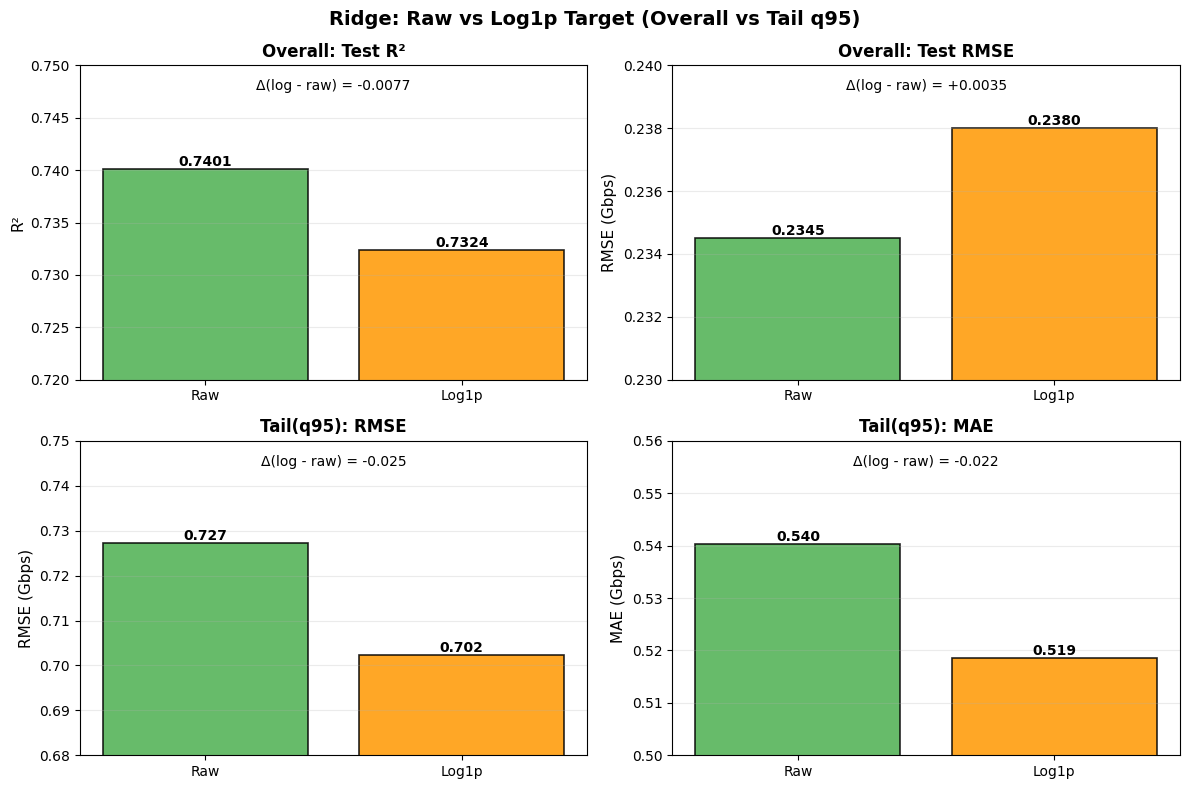

In [38]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

models = ['Raw', 'Log1p']
colors = ['#4CAF50', '#FF9800']

def barplot(ax, title, ylabel, raw_val, log_val, fmt="{:.4f}", ylim=None, delta_fmt="{:+.4f}"):
    vals = [raw_val, log_val]
    bars = ax.bar(models, vals, color=colors, alpha=0.85, edgecolor='black', linewidth=1.2)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=11)
    if ylim:
        ax.set_ylim(ylim)
    ax.grid(axis='y', alpha=0.25)

    # value labels
    for bar, v in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2, v, fmt.format(v),
                ha='center', va='bottom', fontsize=10, fontweight='bold')

    # delta text (simple)
    delta = log_val - raw_val
    ax.text(0.5, 0.92, f"Δ(log - raw) = {delta_fmt.format(delta)}",
            transform=ax.transAxes, ha='center', fontsize=10)

# Overall
barplot(axes[0,0], "Overall: Test R²", "R²",
        best_raw["test_r2"], best_log["test_r2"],
        fmt="{:.4f}", ylim=(0.72, 0.75), delta_fmt="{:+.4f}")

barplot(axes[0,1], "Overall: Test RMSE", "RMSE (Gbps)",
        best_raw["test_rmse"], best_log["test_rmse"],
        fmt="{:.4f}", ylim=(0.23, 0.24), delta_fmt="{:+.4f}")

# Tail q95
barplot(axes[1,0], "Tail(q95): RMSE", "RMSE (Gbps)",
        best_raw["test_rmse_peak"], best_log["test_rmse_peak"],
        fmt="{:.3f}", ylim=(0.68, 0.75), delta_fmt="{:+.3f}")

barplot(axes[1,1], "Tail(q95): MAE", "MAE (Gbps)",
        best_raw["test_mae_peak"], best_log["test_mae_peak"],
        fmt="{:.3f}", ylim=(0.50, 0.56), delta_fmt="{:+.3f}")

fig.suptitle("Ridge: Raw vs Log1p Target (Overall vs Tail q95)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**Result:**
- **Raw target** performs better overall: RMSE=0.2345, R²=0.740.
- **Log1p target** slightly improves peak errors (top 5% within each test fold)
  but degrades overall performance (RMSE=0.238, R²=0.732).


RAW target Ridge performs better overall (higher test R², lower test RMSE on the full hourly distribution).

LOG1P target Ridge performs slightly worse on the overall distribution, but improves peak-focused metrics (lower peak RMSE/MAE on the top 1% hours).

Interpretation

RAW-y prioritizes absolute accuracy in Gbps: it fits typical hours and preserves magnitude in real units, which is best for short-horizon operational forecasting (1-step-ahead).

LOG1P-y reduces the penalty gap between normal hours and peaks, making the model less likely to severely underpredict extremes, which can be useful when the business objective is tail-sensitive (e.g., risk management or estimating upper percentiles such as p95).

Decision for this project (1-step-ahead hourly forecasting)

Our current task is 1-step-ahead forecasting of hourly load and we evaluate error directly in Gbps.
Therefore, we keep the RAW target as the primary modelling choice.

Forward-looking note (billing / capacity planning by p95)

For the future objective of tariff selection based on p95, we may revisit the target definition:

Use RAW-y models when we need reliable predictions in absolute units (Gbps) for typical operations.

Consider log1p(y) (or quantile-oriented approaches) when the objective is explicitly tail-sensitive (p95 / peak risk), even if overall RMSE slightly worsens.

## <a id="model-3-ridge-on-weekly-features"></a>Model 4: Ridge on weekly features 

Our idea is to test our best fo far model on a dataset with weekly lag features to check the feature importance and quality of the model

In [39]:
df_model_week = pd.read_csv('/data/model_dataset_168.csv') # change it to your path

In [40]:
df_model_week.head()

,datetime_utc,y,hour,weekday,is_weekend,sin_hour,cos_hour,sin_wd,cos_wd,lag_1,...,roll_mean_168,roll_std_168,xen200_cpu_util_avg,xen201_cpu_util_avg,xen203_cpu_util_avg,new_vms_ee_prev_month,new_users_ee_prev_month,roll_min_24,traffic_range_24h,lag1_sin_hour
0,2025-08-26 12:00:00+00:00,1.317804,12,1,0,1.224647e-16,-1.000000,0.781831,0.62349,1.464245,...,1.161545,0.325974,16.3919,12.3302,14.2139,38.0,33.0,0.498227,1.161743,1.793183e-16
1,2025-08-26 13:00:00+00:00,1.352293,13,1,0,-2.588190e-01,-0.965926,0.781831,0.62349,1.317804,...,1.161119,0.325721,16.2465,11.8925,13.8252,38.0,33.0,0.498227,1.161743,-3.410727e-01
2,2025-08-26 14:00:00+00:00,1.625480,14,1,0,-5.000000e-01,-0.866025,0.781831,0.62349,1.352293,...,1.161776,0.325996,16.7666,12.1445,15.3802,38.0,33.0,0.498227,1.161743,-6.761466e-01
3,2025-08-26 15:00:00+00:00,1.358414,15,1,0,-7.071068e-01,-0.707107,0.781831,0.62349,1.625480,...,1.163778,0.327810,19.0642,11.0706,15.7619,38.0,33.0,0.498227,1.161743,-1.149388e+00
4,2025-08-26 16:00:00+00:00,1.354726,16,1,0,-8.660254e-01,-0.500000,0.781831,0.62349,1.358414,...,1.163682,0.327750,17.9257,11.3977,18.7984,38.0,33.0,0.498227,1.161743,-1.176421e+00


In [41]:
df_model_week.columns

Index(['datetime_utc', 'y', 'hour', 'weekday', 'is_weekend', 'sin_hour',
       'cos_hour', 'sin_wd', 'cos_wd', 'lag_1', 'lag_24', 'lag_168',
       'roll_mean_24', 'roll_max_24', 'roll_std_24', 'roll_mean_168',
       'roll_std_168', 'xen200_cpu_util_avg', 'xen201_cpu_util_avg',
       'xen203_cpu_util_avg', 'new_vms_ee_prev_month',
       'new_users_ee_prev_month', 'roll_min_24', 'traffic_range_24h',
       'lag1_sin_hour'],
      dtype='object')

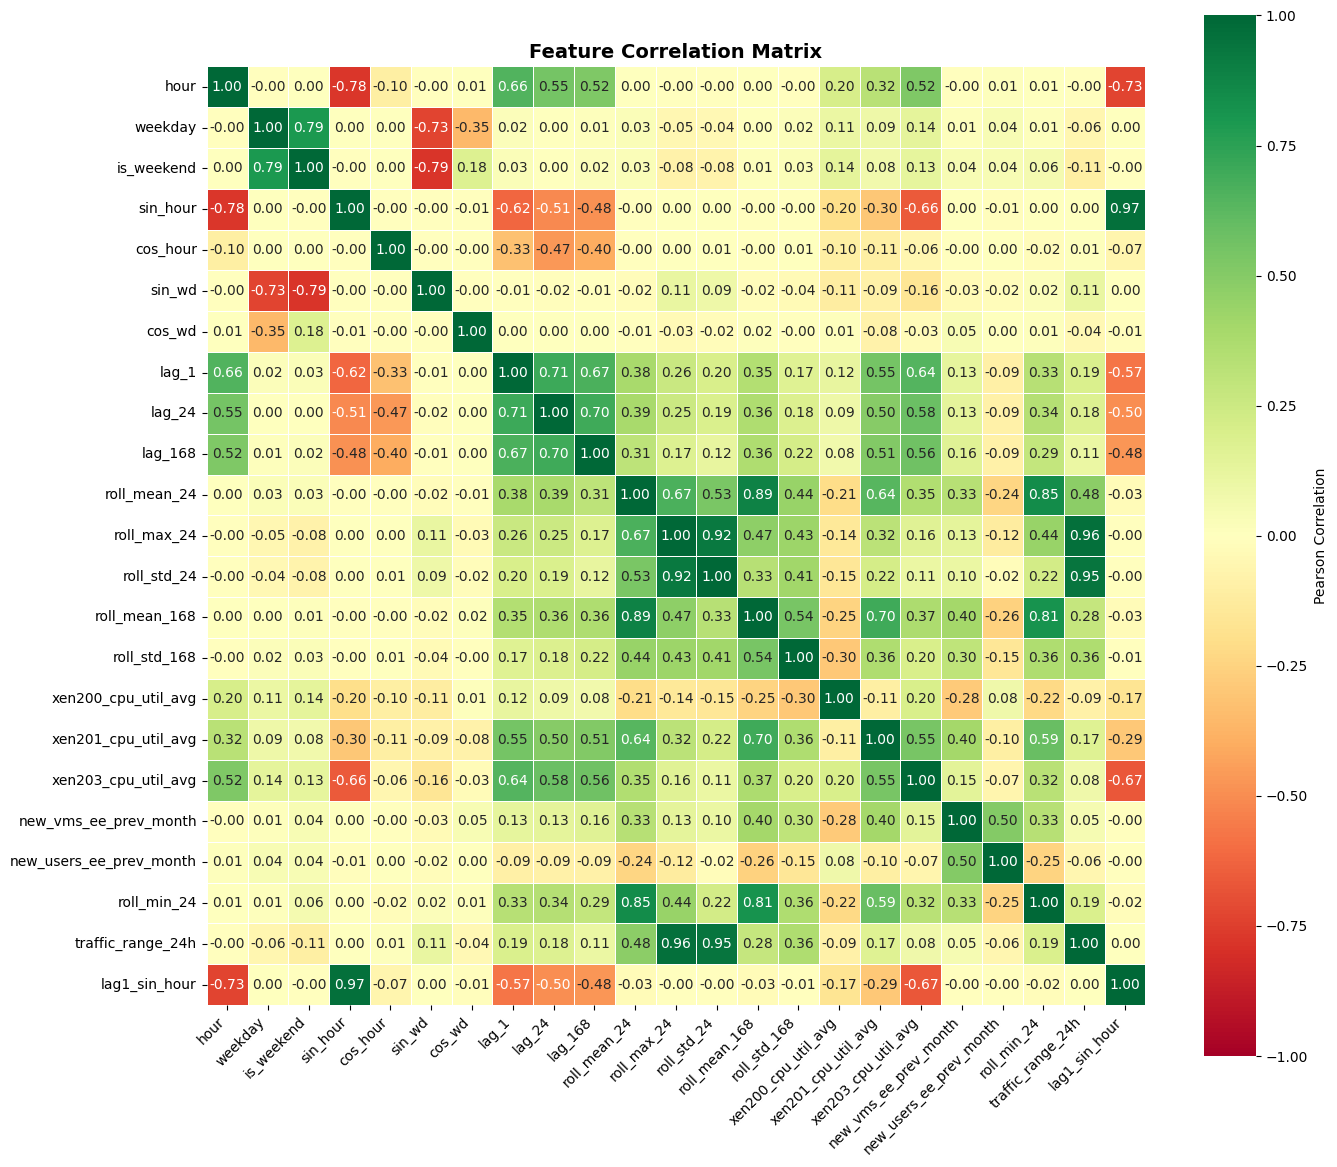

In [42]:
# Feature columns (exclude datetime and target)
feature_cols = [col for col in df_model_week.columns 
                if col not in ['datetime_utc', 'y']]

# Compute correlation
corr = df_model_week[feature_cols].corr(method="pearson")

# Plot
plt.figure(figsize=(14, 12))
sns.heatmap(corr, 
            annot=True,           # Show values
            fmt=".2f",            # 2 decimal places
            cmap="RdYlGn",        # Red-Yellow-Green
            vmin=-1, vmax=1,      # Correlation range
            center=0,             # Center colormap at 0
            square=True,          # Square cells
            linewidths=0.5,       # Grid lines
            cbar_kws={"label": "Pearson Correlation"})

plt.title("Feature Correlation Matrix", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [43]:
# making the same splits but on weekly features dataset, keep 24h gap

n_week = len(df_model_week)

splits_week = make_walk_forward_splits_range(
    n_week,
    n_splits=3,
    test_size=503,
    gap=24
)

print_splits(splits_week)

Folds (train_start, train_end, test_start, test_end):
Fold 1: train=[0:1844) test=[1868:2371)  (n_test=503)
Fold 2: train=[0:2347) test=[2371:2874)  (n_test=503)
Fold 3: train=[0:2850) test=[2874:3353)  (n_test=479)


In [44]:
# Ridge CV on a weekly dataset

alphas = np.logspace(-3, 3, 25)

ridge_results_week = ridge_cv(
    df_model_week,
    alphas=alphas,
    splits=splits_week,
    peak_q=0.95
)

best_week = ridge_results_week.iloc[0]
best_week_alpha = best_week["alpha"]

print("Best Result on a WEEK-feature Ridge:")
print(best_week[["alpha","train_r2","test_r2","train_rmse","test_rmse","test_rmse_peak","test_mae_peak"]])

Best Result on a WEEK-feature Ridge:
alpha             0.001000
train_r2          0.748088
test_r2           0.741556
train_rmse        0.215619
test_rmse         0.234025
test_rmse_peak    0.728904
test_mae_peak     0.542915
Name: 0, dtype: float64


In [45]:
# comparison with basic Ridge (only daly features)

comparison = pd.DataFrame([
    {"model":"Ridge (daily features)", "best_alpha": best_raw["alpha"],
     "test_r2": best_raw["test_r2"], "test_rmse": best_raw["test_rmse"],
     "peak_rmse": best_raw["test_rmse_peak"], "peak_mae": best_raw["test_mae_peak"]},

    {"model":"Ridge (daily + weekly)", "best_alpha": best_week["alpha"],
     "test_r2": best_week["test_r2"], "test_rmse": best_week["test_rmse"],
     "peak_rmse": best_week["test_rmse_peak"], "peak_mae": best_week["test_mae_peak"]},
]).sort_values("test_rmse")

display(comparison)

,model,best_alpha,test_r2,test_rmse,peak_rmse,peak_mae
1,Ridge (daily + weekly),0.001,0.741556,0.234025,0.728904,0.542915
0,Ridge (daily features),0.001,0.740103,0.234509,0.727244,0.540380


In [46]:
# feature importance analysis

DT, TARGET = "datetime_utc", "y"
feature_cols_week = [c for c in df_model_week.columns if c not in [DT, TARGET]]

X_all = df_model_week[feature_cols_week].to_numpy()
y_all = df_model_week[TARGET].to_numpy()

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=best_week_alpha))
])

pipe.fit(X_all, y_all)

coefs = pipe.named_steps["model"].coef_
imp = pd.DataFrame({
    "feature": feature_cols_week,
    "coef": coefs,
    "abs_coef": np.abs(coefs)
}).sort_values("abs_coef", ascending=False)

display(imp[["feature","coef"]].head(15))

,feature,coef
7,lag_1,0.188969
22,lag1_sin_hour,-0.144820
3,sin_hour,0.130923
4,cos_hour,-0.113806
8,lag_24,0.058685
17,xen203_cpu_util_avg,0.046774
9,lag_168,0.036872
0,hour,0.028703
16,xen201_cpu_util_avg,0.025709
10,roll_mean_24,0.024463


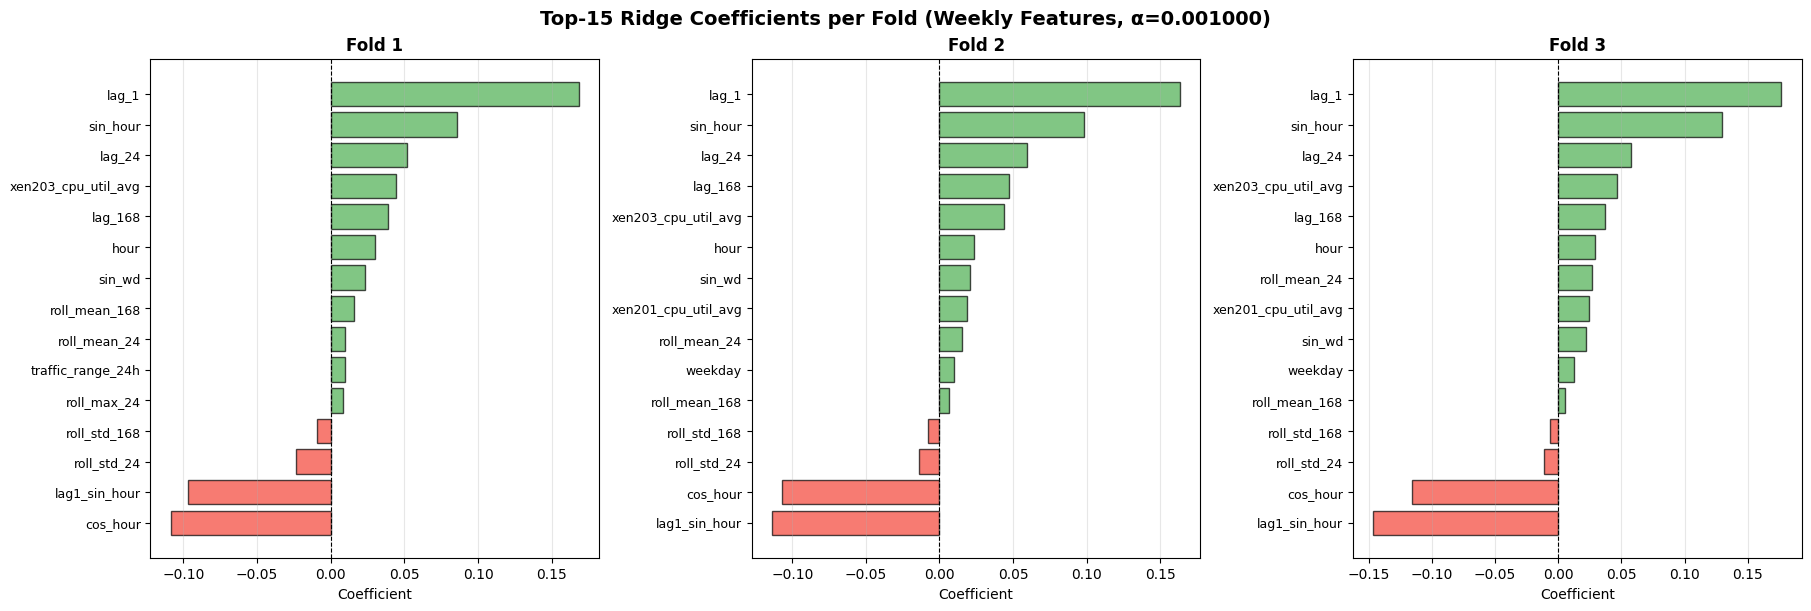

In [47]:
# feature importance per fold

# retrain Ridge (weekly features) on each fold


best_week_alpha = best_week['alpha']

feature_cols_week = [c for c in df_model_week.columns if c not in ["datetime_utc", "y"]]
X_all = df_model_week[feature_cols_week].to_numpy()
y_all = df_model_week["y"].to_numpy()

fold_pipes = []

for i, (tr_s, tr_e, te_s, te_e) in enumerate(splits, start=1):
    X_tr, y_tr = X_all[tr_s:tr_e], y_all[tr_s:tr_e]
    
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("ridge", Ridge(alpha=best_week_alpha))
    ])
    
    pipe.fit(X_tr, y_tr)
    fold_pipes.append(pipe)
    

# Ridge (Weekly Features) coefficients visualization


top_k = 15  # show top15 features

fig, axes = plt.subplots(1, len(fold_pipes), figsize=(18, 6), constrained_layout=True)
fig.suptitle(f"Top-{top_k} Ridge Coefficients per Fold (Weekly Features, α={best_week_alpha:.6f})", 
             fontsize=14, fontweight='bold')

for idx, fitted_pipe in enumerate(fold_pipes):
    fold_num = idx + 1
    ridge_model = fitted_pipe.named_steps["ridge"]

    coef_df = pd.DataFrame({
        "feature": feature_cols_week, 
        "coef": ridge_model.coef_
    })
    coef_df["abs_coef"] = coef_df["coef"].abs()
    coef_df = coef_df.sort_values("abs_coef", ascending=False).head(top_k)
    coef_df = coef_df.sort_values("coef")  # so barh is readable

    ax = axes[idx]
    
    # Color bars: red for negative, green for positive
    colors = ['#F44336' if c < 0 else '#4CAF50' for c in coef_df["coef"]]
    ax.barh(coef_df["feature"], coef_df["coef"], color=colors, alpha=0.7, edgecolor='black')
    
    # Add vertical line at zero
    ax.axvline(0, color='black', linewidth=0.8, linestyle='--')
    
    ax.set_title(f"Fold {fold_num}", fontsize=12, fontweight='bold')
    ax.set_xlabel("Coefficient", fontsize=10)
    ax.tick_params(axis='y', labelsize=9)
    ax.grid(axis='x', alpha=0.3)

plt.savefig('ridge_weekly_coefficients.png', dpi=150, bbox_inches='tight')
plt.show()


 Top 20 Features: Daily vs Weekly Coefficients
              feature     Daily    Weekly  Difference
                lag_1  0.183421  0.176438   -0.006983
        lag1_sin_hour -0.158856 -0.146340    0.012516
             sin_hour  0.139552  0.129632   -0.009920
             cos_hour -0.123272 -0.115573    0.007700
               lag_24  0.066623  0.057299   -0.009324
  xen203_cpu_util_avg  0.050714  0.046752   -0.003962
              lag_168  0.000000  0.037049    0.037049
                 hour  0.032738  0.029018   -0.003720
         roll_mean_24  0.028011  0.026749   -0.001262
  xen201_cpu_util_avg  0.029120  0.024699   -0.004421
               sin_wd  0.024121  0.022025   -0.002096
              weekday  0.013404  0.012064   -0.001340
          roll_std_24 -0.014362 -0.010900    0.003462
         roll_std_168  0.000000 -0.006221   -0.006221
        roll_mean_168  0.000000  0.004967    0.004967
new_vms_ee_prev_month -0.000490 -0.004961   -0.004471
               cos_wd  0.004243  0

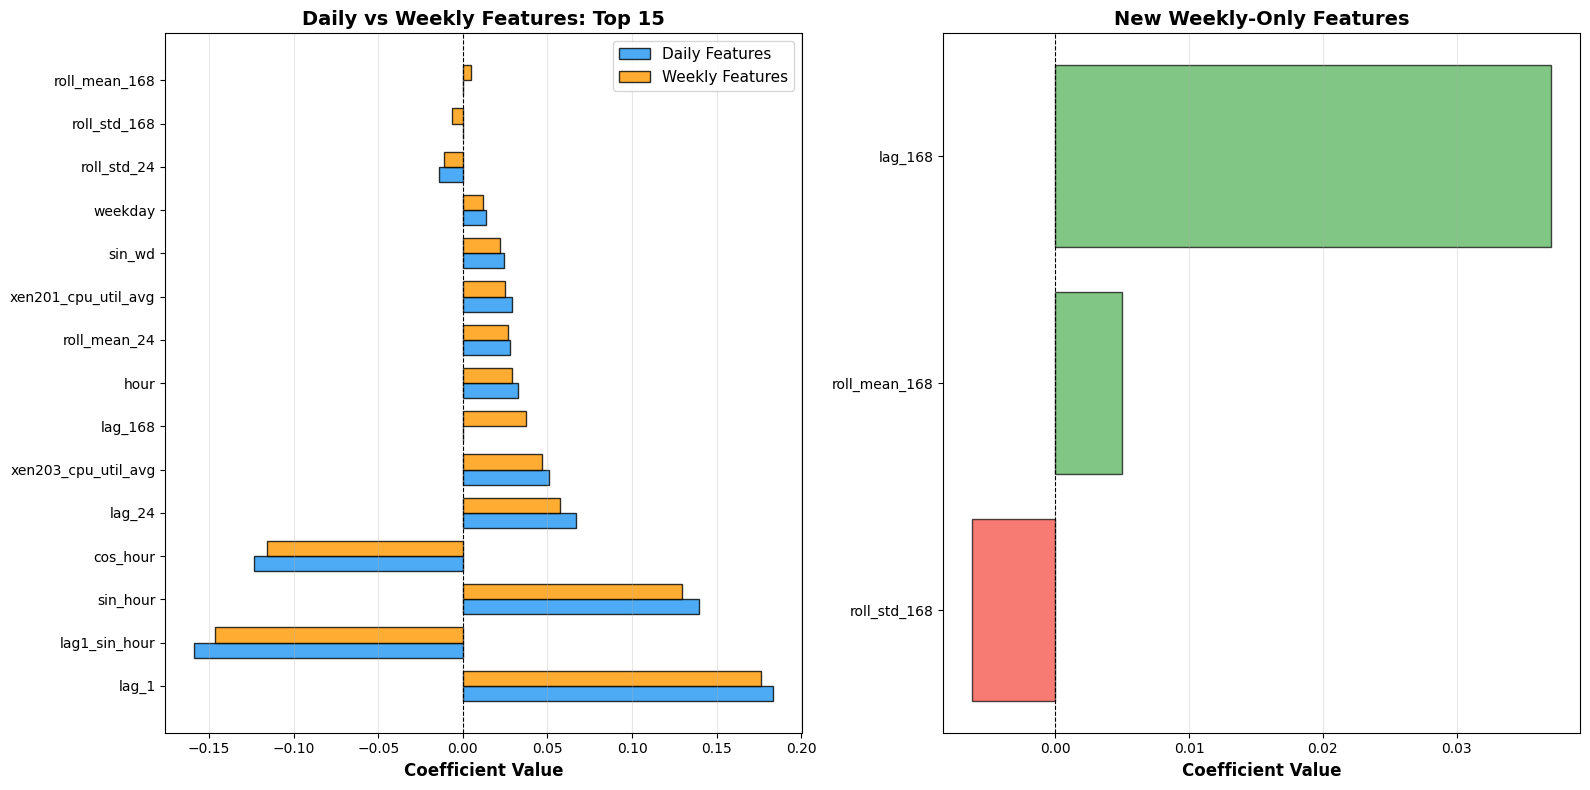

In [48]:
# Daily vs Weekly Coefficients Comparison

# Retrain both models on last fold for comparison
tr_s, tr_e, te_s, te_e = splits[-1]

# Daily features model
feature_cols_daily = [c for c in df_model.columns if c not in ["datetime_utc", "y"]]
X_tr_daily = df_model.iloc[tr_s:tr_e][feature_cols_daily].to_numpy()
y_tr = df_model.iloc[tr_s:tr_e]["y"].to_numpy()

pipe_daily = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=best_raw['alpha']))  # ← твой best alpha для daily
])
pipe_daily.fit(X_tr_daily, y_tr)

# Weekly features model
X_tr_week = df_model_week.iloc[tr_s:tr_e][feature_cols_week].to_numpy()

pipe_week = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=best_week_alpha))
])
pipe_week.fit(X_tr_week, y_tr)

# Extract coefficients
coef_daily_dict = dict(zip(feature_cols_daily, pipe_daily.named_steps['ridge'].coef_))
coef_week_dict = dict(zip(feature_cols_week, pipe_week.named_steps['ridge'].coef_))

# Common features
common_features = set(feature_cols_daily) & set(feature_cols_week)
weekly_only = set(feature_cols_week) - set(feature_cols_daily)

comparison_df = pd.DataFrame([
    {
        'feature': f,
        'Daily': coef_daily_dict.get(f, 0),
        'Weekly': coef_week_dict.get(f, 0),
        'Difference': coef_week_dict.get(f, 0) - coef_daily_dict.get(f, 0)
    }
    for f in sorted(common_features, key=lambda x: abs(coef_week_dict.get(x, 0)), reverse=True)
])

# Add weekly-only features
for f in weekly_only:
    comparison_df = pd.concat([comparison_df, pd.DataFrame([{
        'feature': f,
        'Daily': 0,
        'Weekly': coef_week_dict[f],
        'Difference': coef_week_dict[f]
    }])], ignore_index=True)

# Sort by absolute weekly coefficient
comparison_df['abs_weekly'] = comparison_df['Weekly'].abs()
comparison_df = comparison_df.sort_values('abs_weekly', ascending=False).head(20)

print("\n Top 20 Features: Daily vs Weekly Coefficients")
print(comparison_df[['feature', 'Daily', 'Weekly', 'Difference']].to_string(index=False))

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: Side-by-side comparison
top_features = comparison_df.head(15)
x = np.arange(len(top_features))
width = 0.35

bars1 = ax1.barh(x - width/2, top_features['Daily'], width, 
                 label='Daily Features', color='#2196F3', alpha=0.8, edgecolor='black')
bars2 = ax1.barh(x + width/2, top_features['Weekly'], width, 
                 label='Weekly Features', color='#FF9800', alpha=0.8, edgecolor='black')

ax1.set_yticks(x)
ax1.set_yticklabels(top_features['feature'], fontsize=10)
ax1.set_xlabel('Coefficient Value', fontsize=12, fontweight='bold')
ax1.set_title('Daily vs Weekly Features: Top 15', fontsize=14, fontweight='bold')
ax1.axvline(0, color='black', linewidth=0.8, linestyle='--')
ax1.legend(fontsize=11)
ax1.grid(axis='x', alpha=0.3)

# Plot 2: New weekly features only
weekly_only_df = comparison_df[comparison_df['Daily'] == 0].sort_values('Weekly')
if len(weekly_only_df) > 0:
    colors_new = ['#F44336' if c < 0 else '#4CAF50' for c in weekly_only_df['Weekly']]
    ax2.barh(weekly_only_df['feature'], weekly_only_df['Weekly'], 
             color=colors_new, alpha=0.7, edgecolor='black')
    ax2.axvline(0, color='black', linewidth=0.8, linestyle='--')
    ax2.set_xlabel('Coefficient Value', fontsize=12, fontweight='bold')
    ax2.set_title('New Weekly-Only Features', fontsize=14, fontweight='bold')
    ax2.tick_params(axis='y', labelsize=10)
    ax2.grid(axis='x', alpha=0.3)
else:
    ax2.text(0.5, 0.5, 'No weekly-only features', ha='center', va='center', fontsize=12)
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('daily_vs_weekly_coefficients.png', dpi=150, bbox_inches='tight')
plt.show()

### Ridge on Weekly-Extended Feature Set (Daily + Weekly Context)

**What we see in the results**
- Adding weekly features produces a **small but consistent improvement** in overall metrics (≈ *+0.2%*), i.e. the model gets *slightly* better on average.
- The **core drivers remain the same** as in the daily-only dataset: `lag_1`, `sin_hour`, `cos_hour`, `lag_24` still dominate the model.
- At the same time, at least one weekly feature becomes **non-trivial**: `lag_168` (same hour last week) appears among meaningful coefficients.

**Why the gain is small (and why that’s okay)**
- The target is strongly driven by **short-term inertia + daily seasonality**, so daily features already explain most of the predictable structure.
- Weekly patterns act as a **secondary correction layer**: they refine predictions when daily signals are ambiguous, but they cannot replace the main daily cycle.

**Why weekly features still matter**
- Even with small metric gains, `lag_168` shows a **real, interpretable signal**: there is information in “last week same hour” that is not fully captured by daily lags/cyclic encoding.
- Weekly context is expected to help under **behavior shifts** (concept drift): when the daily pattern changes, weekly reference points can provide extra stability.
- Weekly features also keep the dataset **future-proof** for longer horizons and for scenarios where “weekday regimes” (Mon–Fri vs weekend) become more important.

**Decision**
We keep the **weekly-extended dataset as the default feature set**:
- it does not materially increase complexity,
- it preserves the strong daily baseline,
- and it adds additional temporal context that may improve robustness when future months introduce new weekly patterns or regime changes.

## <a id="conclusion"></a>Conclusion


We evaluated time-safe walk-forward CV (3 folds) with a 24h gap to avoid leakage from near-boundary observations.

Simple baselines show that:

Naive (lag_1) is a strong reference point,

Seasonal (lag_24) alone performs worse than naive → daily repetition exists, but is not sufficient by itself.

Ridge Regression with standardized features delivered the best overall performance among tested models:

stable results across folds,

very small train–test gap (low overfitting risk),

coefficients are consistent in sign and magnitude so learned patterns are robust.

Ridge performance is insensitive to α across a wide plateau so regularization mainly matters only at very large α (where performance degrades).
We therefore selected α from the plateau (practical & stable choice).

XGBoost (baseline + early stopping + smoother settings) did not outperform Ridge in this setup:

likely because the signal is largely linear + seasonal, already captured well by engineered lag/rolling/cyclical features,

early stopping indicates limited benefit from deeper/nonlinear splits given current data and feature set.

**Final model choice**: Ridge Regression (gap=24, walk-forward CV), as a strong, stable baseline suitable for deployment and further monitoring on new months (Jan/Feb) to detect regime shifts.